# Experiment 1

- Rank metrics for each model for store & upc. The metrics are the average over all folds. (total of 52 weeks)
- Plots over time


In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
import yaml
from tqdm import tqdm 
from glob import glob

# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path,'src'))

from metrics import *
from utils import *

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['breakfast']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)

In [2]:
stores = list(params['breakfast']['dataset']['store_ids'].keys())
upcs = list(params['breakfast']['dataset']['upc_ids'].keys())

full_search = list(itertools.product(stores, upcs))

date_ranges = make_dates(params['breakfast']['experiment_dates'])['test_end']

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Select a paid of store and upc:
# Currently only has 3 to 7.
store, upc = full_search[0]

In [4]:
# Aggregate all predictions of each model for exp1

all_stores_upc = {}
base_mae_rmse_ll = []

for store, upc in full_search:
    xgb_exp1 =[]
    lstm_exp1 =[]
    sarima_exp1 =[]
    prophet_exp1 =[]
    
    for fpath in glob(str(proj_path / f'data/04_results/*')):
        # Ignore files in those two folders
        if ('olist' in fpath) | ('breakfast' in fpath):
            pass
        else:
            xgb_exp1.append(pd.read_csv(os.path.join(fpath,f'xgb_exp1_{store}_{upc}.csv')))
            lstm_exp1.append(pd.read_csv(os.path.join(fpath,f'lstm_exp1_{store}_{upc}.csv')))
            sarima_exp1.append(pd.read_csv(os.path.join(fpath,f'sarima_{store}_{upc}.csv')))
            prophet_exp1.append(pd.read_csv(os.path.join(fpath,f'prophet_{store}_{upc}.csv')))

    xgb_exp1 = pd.concat(xgb_exp1).reset_index(drop=True)
    lstm_exp1 = pd.concat(lstm_exp1).reset_index(drop=True)
    sarima_exp1 = pd.concat(sarima_exp1).reset_index(drop=True)
    prophet_exp1 = pd.concat(prophet_exp1).reset_index(drop=True)
    
    # clean up each experiments and standardize their outputs here
    xgb_exp1 = xgb_exp1.rename(columns={'test_predictions':'y_pred_xgb',
                                        'WEEK_END_DATE':'dates'})[['dates','y_pred_xgb','y_true']]
    lstm_exp1['dates'] = xgb_exp1['dates']
    lstm_exp1.drop(columns='Unnamed: 0',inplace=True)
    lstm_exp1 = lstm_exp1.rename(columns={'y_pred':'y_pred_lstm'})
    sarima_exp1.drop(columns='Unnamed: 0',inplace=True)
    # Choose next day VS long term here
    sarima_exp1 = sarima_exp1.rename(columns={'y_pred_lt': 'y_pred_lt_sarima'}) # can be lt_preds
    sarima_exp1 = sarima_exp1.rename(columns={'y_pred_nd':'y_pred_sarima'})
    prophet_exp1.drop(columns='Unnamed: 0',inplace=True)
    prophet_exp1 = prophet_exp1.rename(columns={'ds':'dates','y':'y_true','preds':'y_pred_prophet'})
    
    xgb_exp1.set_index('dates', inplace=True)
    lstm_exp1.set_index('dates', inplace=True)
    sarima_exp1.set_index('dates', inplace=True)
    prophet_exp1.set_index('dates', inplace=True)

    df = pd.concat([xgb_exp1[['y_true','y_pred_xgb']],
               sarima_exp1['y_pred_sarima'],
               sarima_exp1['y_pred_lt_sarima'],
               lstm_exp1['y_pred_lstm'],
               prophet_exp1['y_pred_prophet']],axis=1)
    all_stores_upc[f'{store}_{upc}'] = df
    
    base_metrics = pd.read_csv(proj_path / catalog['results']['dir'] / 'breakfast' / f'naive_training_{store}_{upc}.csv')
    base_mae_rmse_ll.append({'store': store,
                             'upc':upc,
                             'base_mae':base_metrics['train_mae'].values[0],
                             'base_rmse':base_metrics['train_rmse'].values[0]})

base_mae_rmse = pd.DataFrame(base_mae_rmse_ll)

In [5]:
def get_min_max(df, date_ranges):
    
    _metrics_xgb = []
    _metrics_sarima = []
    _metrics_lstm = []
    _metrics_prophet = []
    
    for window in date_ranges.itertuples():
        # Filter period
        temp = df[(pd.to_datetime(df.index) >= window[5]) & 
                  (pd.to_datetime(df.index) <= window[6])]
        _metrics_xgb.append(get_metrics(temp['y_true'],temp['y_pred_xgb']))
        _metrics_sarima.append(get_metrics(temp['y_true'],temp['y_pred_sarima']))
        _metrics_lstm.append(get_metrics(temp['y_true'],temp['y_pred_lstm']))
        _metrics_prophet.append(get_metrics(temp['y_true'],temp['y_pred_prophet']))
    
    # Get the min and max for each metric for each model
    return pd.DataFrame({'model':['sarima','prophet','xgb','lstm'],
                      'min_wape':[pd.DataFrame(_metrics_sarima)['wape'].min(),
                                 pd.DataFrame(_metrics_prophet)['wape'].min(),
                                 pd.DataFrame(_metrics_xgb)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm)['wape'].min()],
                      'min_rmse':[pd.DataFrame(_metrics_sarima)['rmse'].min(),
                                 pd.DataFrame(_metrics_prophet)['rmse'].min(),
                                 pd.DataFrame(_metrics_xgb)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].min()],
                      'min_r2':[pd.DataFrame(_metrics_sarima)['r2'].min(),
                                 pd.DataFrame(_metrics_prophet)['r2'].min(),
                                 pd.DataFrame(_metrics_xgb)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm)['r2'].min()],
                     'min_mape':[pd.DataFrame(_metrics_sarima)['mape'].min(),
                                 pd.DataFrame(_metrics_prophet)['mape'].min(),
                                 pd.DataFrame(_metrics_xgb)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm)['mape'].min()],
                     'max_wape':[pd.DataFrame(_metrics_sarima)['wape'].max(),
                                 pd.DataFrame(_metrics_prophet)['wape'].max(),
                                 pd.DataFrame(_metrics_xgb)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm)['wape'].max()],
                      'max_rmse':[pd.DataFrame(_metrics_sarima)['rmse'].max(),
                                 pd.DataFrame(_metrics_prophet)['rmse'].max(),
                                 pd.DataFrame(_metrics_xgb)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].max()],
                      'max_r2':[pd.DataFrame(_metrics_sarima)['r2'].max(),
                                 pd.DataFrame(_metrics_prophet)['r2'].max(),
                                 pd.DataFrame(_metrics_xgb)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm)['r2'].max()],
                     'max_mape':[pd.DataFrame(_metrics_sarima)['mape'].max(),
                                 pd.DataFrame(_metrics_prophet)['mape'].max(),
                                 pd.DataFrame(_metrics_xgb)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm)['mape'].max()],
                     'max_mae':[pd.DataFrame(_metrics_sarima)['mae'].max(),
                                 pd.DataFrame(_metrics_prophet)['mae'].max(),
                                 pd.DataFrame(_metrics_xgb)['mae'].max(),
                                 pd.DataFrame(_metrics_lstm)['mae'].max()],
                     'min_mae':[pd.DataFrame(_metrics_sarima)['mae'].min(),
                                 pd.DataFrame(_metrics_prophet)['mae'].min(),
                                 pd.DataFrame(_metrics_xgb)['mae'].min(),
                                 pd.DataFrame(_metrics_lstm)['mae'].min()]})
    

In [6]:
metrics_df = pd.DataFrame()
metrics_mase_rmsse = pd.DataFrame()

for store, upc in full_search:
    
    temp = all_stores_upc[f'{store}_{upc}']
    
    # Get metrics for each model
    metrics_xgb = get_metrics(temp['y_true'],temp['y_pred_xgb'])
    metrics_sarima = get_metrics(temp['y_true'],temp['y_pred_sarima'])
    metrics_lstm = get_metrics(temp['y_true'],temp['y_pred_lstm'])
    metrics_prophet = get_metrics(temp['y_true'],temp['y_pred_prophet'])
    
    results = pd.DataFrame([metrics_sarima,metrics_prophet,metrics_xgb,metrics_lstm], 
                       index=['sarima','prophet','xgb','lstm'])
    results['store'] = store
    results['upc'] = upc
    results = results.reset_index().rename(columns={'index':'model'})
    
    # Calculate the ranks for each metric
    results['rank_mape'] = results.rank(axis=0)['mape']
    results['rank_wape'] = results.rank(axis=0)['wape']
    results['rank_rmse'] = results.rank(axis=0)['rmse']
    results['rank_mae'] = results.rank(axis=0)['mae']
    results['rank_r2'] = results.rank(axis=0, ascending=False)['r2']
    
    # Add rank for rmsse and mase
    results = results.merge(base_mae_rmse, how='left', on=['store','upc'])
    results['mase'] = results['mae'] / results['base_mae']
    results['rmsse'] = results['rmse'] / results['base_rmse']
    results['rank_rmsse'] = results.rank(axis=0)['rmsse']
    results['rank_mase'] = results.rank(axis=0)['mase']
    
    min_max_df = get_min_max(df, make_dates(params['breakfast']['experiment_dates']))
    results = results.merge(min_max_df, how='inner', on='model')  
    
    # Calculate the minimum and maximum of each fold
    metrics_df = metrics_df.append(results).reset_index(drop=True)

In [7]:
metrics_df[['model', 'store', 'upc', 'mase', 'rmsse', 'rank_mase','rank_rmsse']]

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model  store         upc      mase     rmsse  rank_mase  rank_rmsse
0    sarima   2277  1600027527  1.080097  0.857683        3.0         3.0
1   prophet   2277  1600027527  1.210489  0.859379        4.0         4.0
2       xgb   2277  1600027527  0.957258  0.801183        2.0         1.0
3      lstm   2277  1600027527  0.934310  0.832479        1.0         2.0
4    sarima   2277  3800031838  1.101288  0.800347        2.0         2.0
5   prophet   2277  3800031838  1.108553  0.812556        3.0         3.0
6       xgb   2277  3800031838  1.218715  0.979685        4.0         4.0
7      lstm   2277  3800031838  0.789534  0.739597        1.0         1.0
8    sarima   2277  1111009477  1.297731  1.226108        3.0         3.0
9   prophet   2277  1111009477  1.281540  1.166543        2.0         1.0
10      xgb   2277  1111009477  1.506113  1.420591        4.0         4.0
11     lstm   2277  1111009477  1.189834  1.188514        1.0         2.0
12   sarima   2277  7192100339  1.290572  1.024666        4.0         3.0
13  prophet   2277  7192100339  0.950171  0.797803        1.0         1.0
14      xgb   2277  7192100339  1.233069  1.108042        3.0         4.0
15     lstm   2277  7192100339  1.050072  0.878360        2.0         2.0
16   sarima    389  1600027527  1.017322  0.744948        3.0         4.0
17  prophet    389  1600027527  1.267040  0.728028        4.0         2.0
18      xgb    389  1600027527  0.795395  0.732820        1.0         3.0
19     lstm    389  1600027527  0.899716  0.590125        2.0         1.0
20   sarima    389  3800031838  1.266645  1.122007        3.0         3.0
21  prophet    389  3800031838  1.538314  1.211893        4.0         4.0
22      xgb    389  3800031838  1.079002  1.055477        2.0         2.0
23     lstm    389  3800031838  0.921890  0.948488        1.0         1.0
24   sarima    389  1111009477  0.993726  0.983280        2.0         2.0
25  prophet    389  1111009477  1.377072  1.328936        4.0         4.0
26      xgb    389  1111009477  1.100712  1.122712        3.0         3.0
27     lstm    389  1111009477  0.918879  0.887241        1.0         1.0
28   sarima    389  7192100339  1.448589  1.127835        4.0         3.0
29  prophet    389  7192100339  1.207551  0.986731        2.0         2.0
30      xgb    389  7192100339  1.416217  1.294296        3.0         4.0
31     lstm    389  7192100339  1.091107  0.953522        1.0         1.0
32   sarima  25229  1600027527  1.040165  0.865430        2.0         2.0
33  prophet  25229  1600027527  1.100705  0.916234        3.0         3.0
34      xgb  25229  1600027527  1.187492  0.999165        4.0         4.0
35     lstm  25229  1600027527  1.002161  0.847535        1.0         1.0
36   sarima  25229  3800031838  0.960400  0.719084        2.0         2.0
37  prophet  25229  3800031838  1.105718  0.773934        4.0         3.0
38      xgb  25229  3800031838  1.055292  0.892055        3.0         4.0
39     lstm  25229  3800031838  0.770789  0.668055        1.0         1.0
40   sarima  25229  1111009477  0.758113  0.751872        2.0         2.0
41  prophet  25229  1111009477  0.723182  0.695713        1.0         1.0
42      xgb  25229  1111009477  1.117039  1.092290        4.0         4.0
43     lstm  25229  1111009477  1.035982  0.903772        3.0         3.0
44   sarima  25229  7192100339  0.942889  0.825371        3.0         3.0
45  prophet  25229  7192100339  0.912594  0.791572        2.0         2.0
46      xgb  25229  7192100339  1.269152  1.076656        4.0         4.0
47     lstm  25229  7192100339  0.853070  0.738186        1.0         1.0

In [8]:
metrics_df

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model          wape        rmse        r2      mape        mae  store  \
0    sarima  12170.621432  103.430146 -0.242741  0.295284  62.882356   2277   
1   prophet  10763.310358  103.634594 -0.247659  0.365357  70.473677   2277   
2       xgb  11857.916820   96.616609 -0.084401  0.231673  55.730769   2277   
3      lstm  12329.506846  100.390743 -0.170776  0.222847  54.394731   2277   
4    sarima   3521.917256   60.008749 -0.277874  0.492415  42.384501   2277   
5   prophet   3520.589314   60.924162 -0.317158  0.513754  42.664086   2277   
6       xgb   4341.408809   73.455245 -0.914716  0.493060  46.903846   2277   
7      lstm   3706.028024   55.453772 -0.091242  0.285782  30.386227   2277   
8    sarima   5972.117523   48.893337 -0.337371  0.202013  37.580878   2277   
9   prophet   5737.032479   46.518095 -0.210588  0.197613  37.112003   2277   
10      xgb   7343.829475   56.648715 -0.795282  0.214849  43.615385   2277   
11     lstm   6095.299925   47.394208 -0.256617  0.172345  34.456282   2277   
12   sarima   1719.546205   42.492624 -0.363631  0.792344  34.297392   2277   
13  prophet   1267.443924   33.084682  0.173346  0.531375  25.251129   2277   
14      xgb   2144.193093   45.950224 -0.594576  0.533829  32.769231   2277   
15     lstm   1717.679181   36.425381 -0.002024  0.546008  27.906022   2277   
16   sarima   6281.300869   88.793727 -0.702716  0.552961  52.587169    389   
17  prophet   4259.721437   86.776974 -0.626247  0.883747  65.495552    389   
18      xgb   6339.453799   87.348110 -0.647724  0.371145  41.115385    389   
19     lstm   5510.048961   70.339678 -0.068509  0.541170  46.507932    389   
20   sarima   4695.101964   80.816074 -0.490896  0.732651  46.865858    389   
21  prophet   4371.542473   87.290443 -0.739343  1.253726  56.917606    389   
22      xgb   5006.680451   76.024035 -0.319331  0.495279  39.923077    389   
23     lstm   4616.549246   68.317803 -0.065417  0.427679  34.109942    389   
24   sarima   1477.908291   22.953612 -0.357904  0.164048  17.431040    389   
25  prophet   1988.598951   31.022574 -1.480405  0.225139  24.155351    389   
26      xgb   1395.112443   26.208484 -0.770316  0.196807  19.307692    389   
27     lstm   1227.433281   20.711683 -0.105599  0.161557  16.118138    389   
28   sarima    917.954079   35.172701 -0.423287  1.256703  28.148272    389   
29  prophet    744.701165   30.772235 -0.089430  1.007306  23.464543    389   
30      xgb   1177.498749   40.363969 -0.874429  0.780780  27.519231    389   
31     lstm    930.936888   29.736560 -0.017332  0.714194  21.201844    389   
32   sarima   5707.321141   74.657014 -0.046275  0.386728  38.692706  25229   
33  prophet   5578.430392   79.039645 -0.172721  0.460531  40.944706  25229   
34      xgb   6182.928399   86.193767 -0.394622  0.416937  44.173077  25229   
35     lstm   5627.313178   73.113273 -0.003453  0.371022  37.279027  25229   
36   sarima   1959.714154   44.328898 -0.272531  0.364275  28.772531  25229   
37  prophet   1914.698648   47.710229 -0.474068  0.456748  33.126088  25229   
38      xgb   2381.890521   54.991957 -0.958361  0.345120  31.615385  25229   
39     lstm   1972.516971   41.183184 -0.098334  0.258114  23.092000  25229   
40   sarima    339.348735   14.048607  0.178250  0.211304  10.623968  25229   
41  prophet    314.963213   12.999282  0.296423  0.205123  10.134449  25229   
42      xgb    485.146477   20.409274 -0.734316  0.325819  15.653846  25229   
43     lstm    451.307723   16.886844 -0.187326  0.302901  14.517940  25229   
44   sarima    334.730003   16.471056 -0.383611  0.378857  12.586929  25229   
45  prophet    353.267614   15.796569 -0.272614  0.326031  12.182510  25229   
46      xgb    463.989183   21.485684 -1.354341  0.469173  16.942308  25229   
47     lstm    357.240017   14.731200 -0.106744  0.301660  11.387904  25229   

           upc  rank_mape  rank_wape  ...    min_wape  min_rmse     min_r2  \
0   1600027527        3.0        3.0  ...  134.729384  5

In [9]:
all_dfs_mase_rmsse = []
for metric in ['rmsse','mase']:
    rank_df = pd.DataFrame(metrics_df.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_mase_rmsse.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))
pd.concat(all_dfs_mase_rmsse,axis=1)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rmsse_1  rmsse_2  rmsse_3  rmsse_4  mase_1  mase_2  mase_3  mase_4
model                                                                      
lstm         8.0      3.0      1.0      NaN     9.0     2.0     1.0     NaN
prophet      3.0      3.0      3.0      3.0     2.0     3.0     2.0     5.0
sarima       NaN      5.0      6.0      1.0     NaN     5.0     5.0     2.0
xgb          1.0      1.0      2.0      8.0     1.0     2.0     4.0     5.0

In [10]:
all_dfs = []
for metric in ['mape','rmse','wape','r2']:
    rank_df = pd.DataFrame(metrics_df.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# View combined of the ranks for each metrics per model
pd.concat(all_dfs,axis=1)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


mape_1  mape_2  mape_3  mape_4  rmse_1  rmse_2  rmse_3  rmse_4  \
model                                                                     
lstm        9.0     1.0     2.0     NaN     8.0     3.0     1.0     NaN   
prophet     2.0     2.0     1.0     7.0     3.0     3.0     3.0     3.0   
sarima      NaN     4.0     6.0     2.0     NaN     5.0     6.0     1.0   
xgb         1.0     5.0     3.0     3.0     1.0     1.0     2.0     8.0   

         wape_1  wape_2  wape_3  wape_4  r2_1  r2_2  r2_3  r2_4  
model                                                            
lstm        1.0     4.0     6.0     1.0   8.0   3.0   1.0   NaN  
prophet    10.0     1.0     NaN     1.0   3.0   3.0   3.0   3.0  
sarima      1.0     5.0     6.0     NaN   NaN   5.0   6.0   1.0  
xgb         NaN     2.0     NaN    10.0   1.0   1.0   2.0   8.0

In [12]:
# View individual ranks for each metrics per model
for df_metric in all_dfs:
    display(df_metric)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rank_mape  mape_1  mape_2  mape_3  mape_4
model                                    
lstm          9.0     1.0     2.0     NaN
prophet       2.0     2.0     1.0     7.0
sarima        NaN     4.0     6.0     2.0
xgb           1.0     5.0     3.0     3.0

rank_rmse  rmse_1  rmse_2  rmse_3  rmse_4
model                                    
lstm          8.0     3.0     1.0     NaN
prophet       3.0     3.0     3.0     3.0
sarima        NaN     5.0     6.0     1.0
xgb           1.0     1.0     2.0     8.0

rank_wape  wape_1  wape_2  wape_3  wape_4
model                                    
lstm          1.0     4.0     6.0     1.0
prophet      10.0     1.0     NaN     1.0
sarima        1.0     5.0     6.0     NaN
xgb           NaN     2.0     NaN    10.0

rank_r2  r2_1  r2_2  r2_3  r2_4
model                          
lstm      8.0   3.0   1.0   NaN
prophet   3.0   3.0   3.0   3.0
sarima    NaN   5.0   6.0   1.0
xgb       1.0   1.0   2.0   8.0

In [13]:
params['breakfast']['dataset']['store_ids']

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{2277: 'OH', 389: 'KY', 25229: 'TX'}

In [14]:
lookup_products = pd.read_csv(os.path.join(proj_path, 
                                           catalog['output_dir']['dir'], 
                                           catalog['output_dir']['products']))

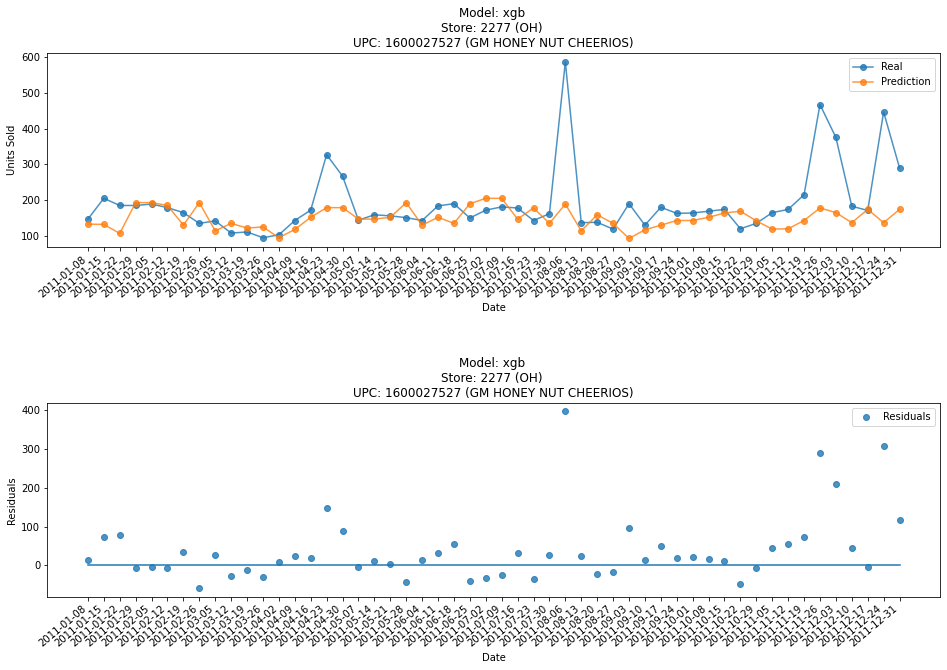

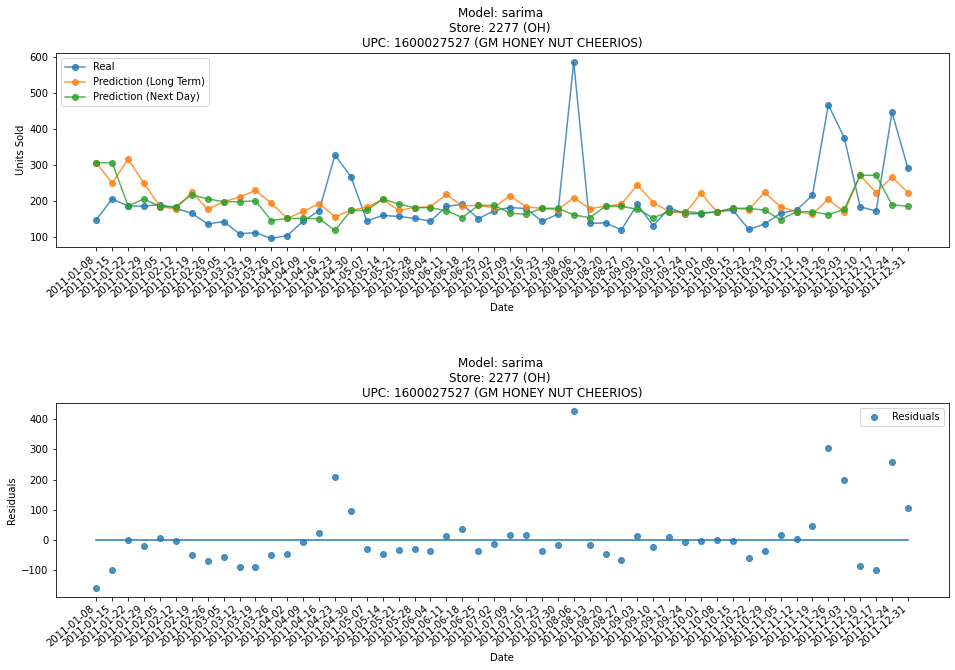

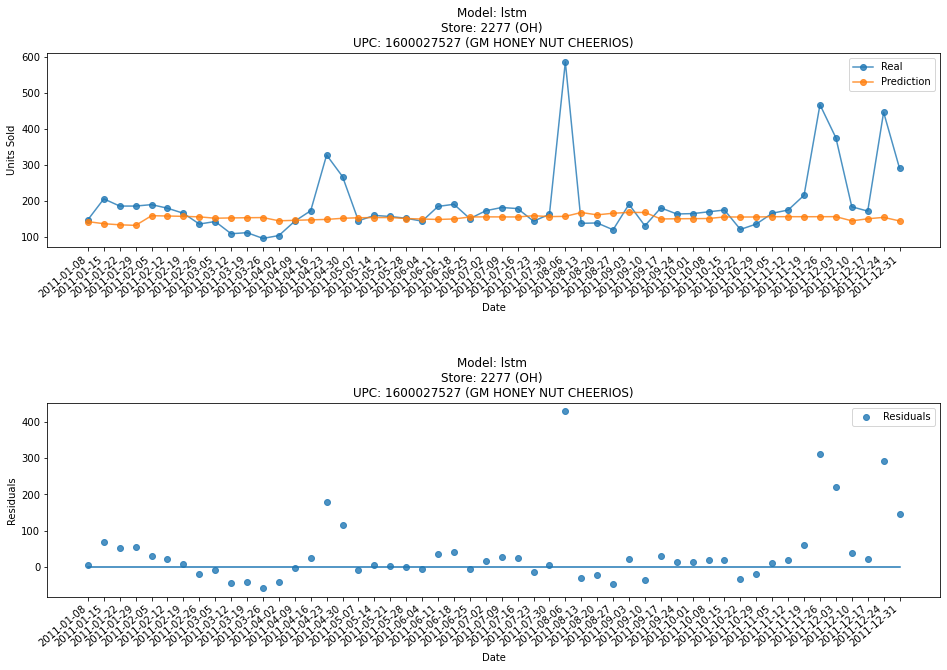

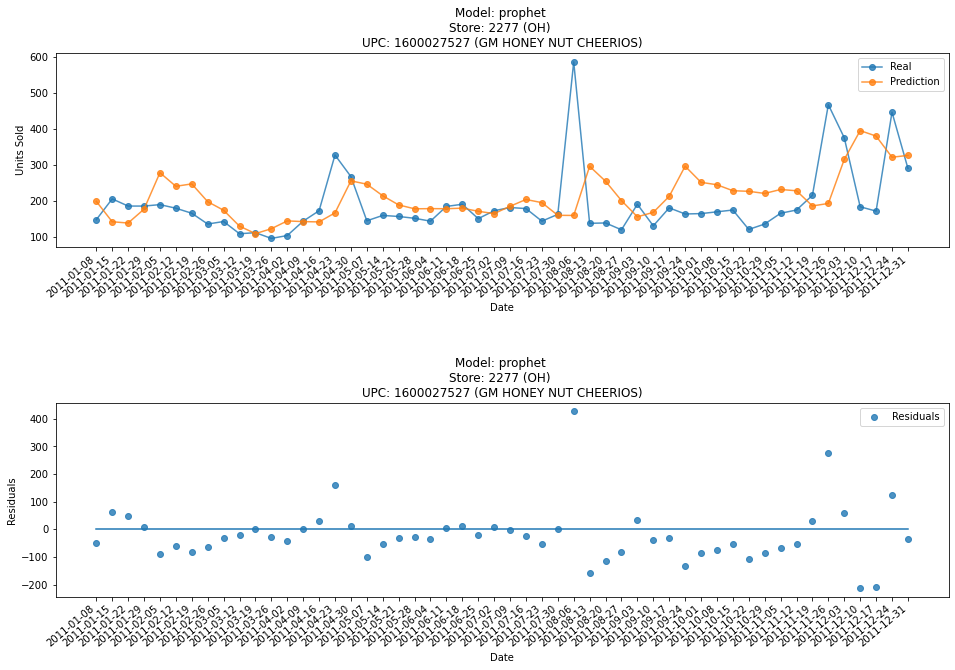

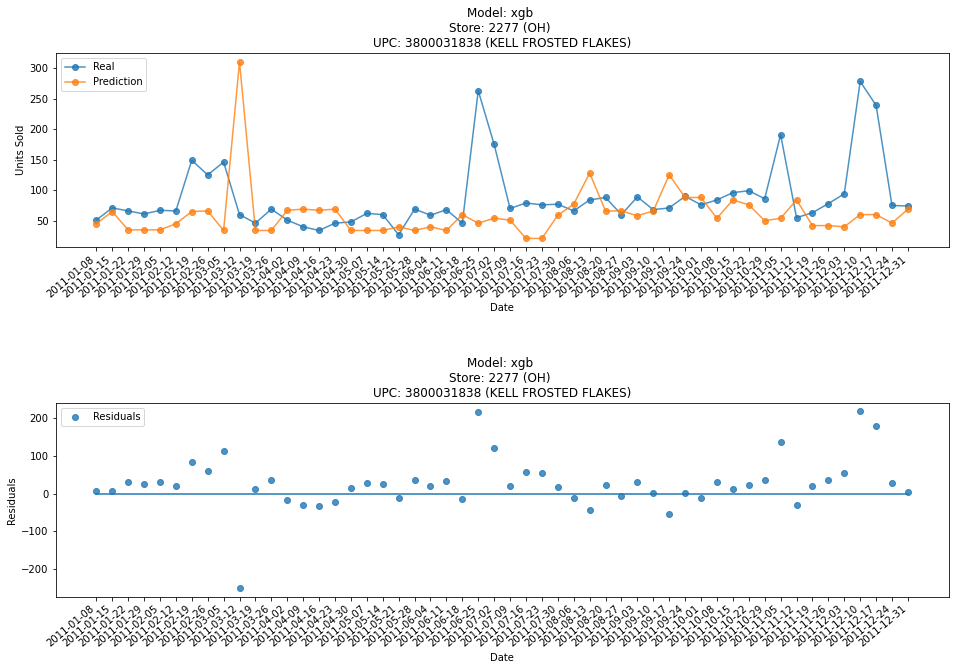

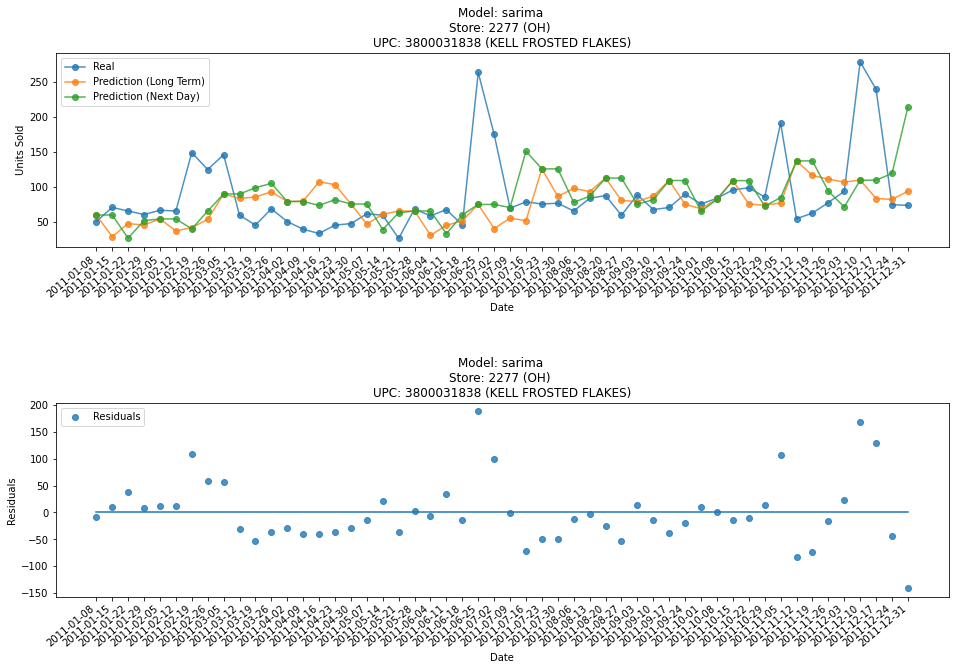

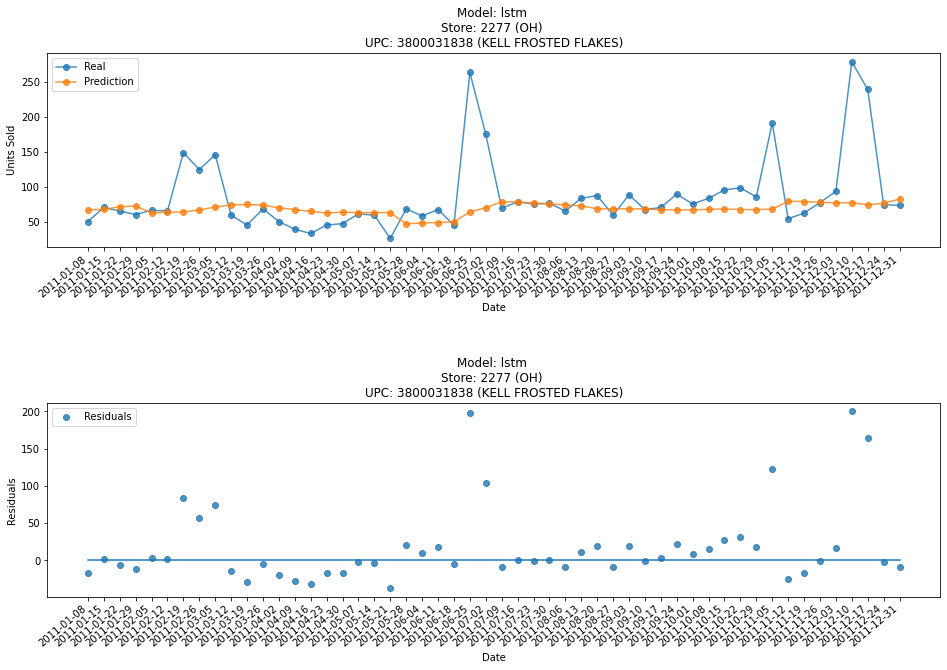

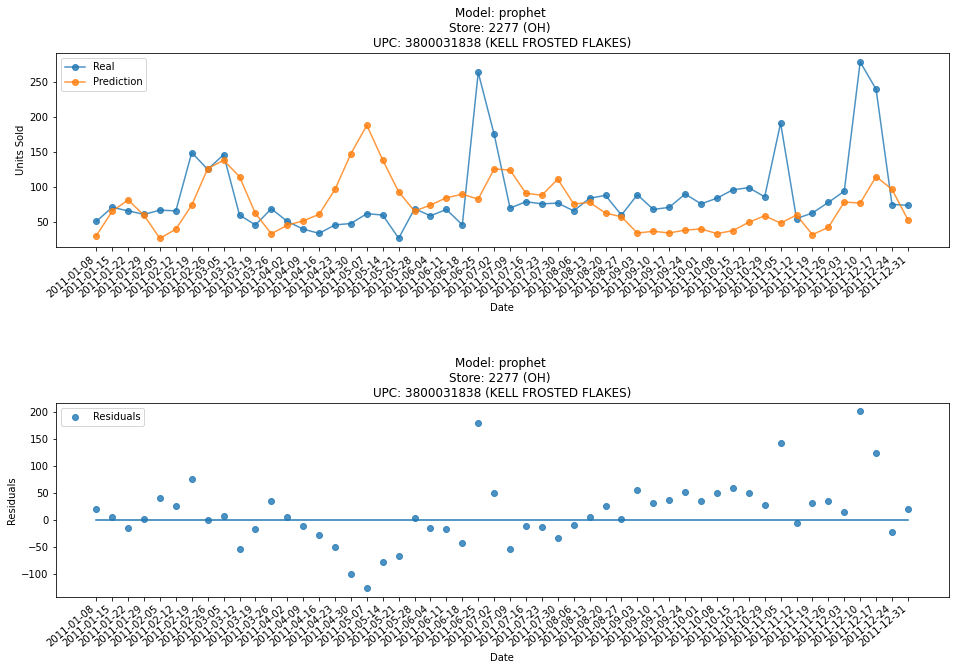

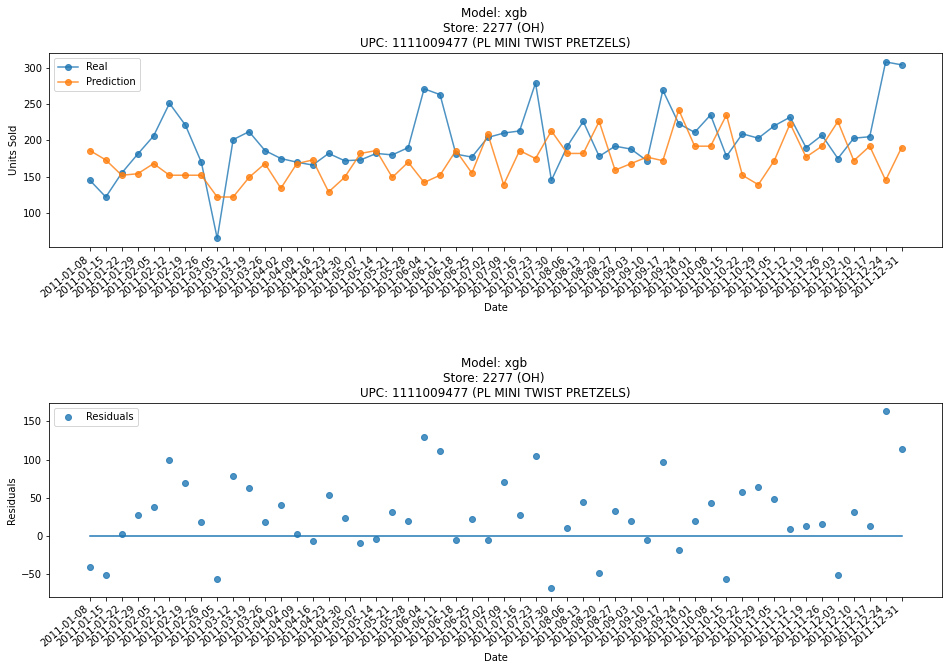

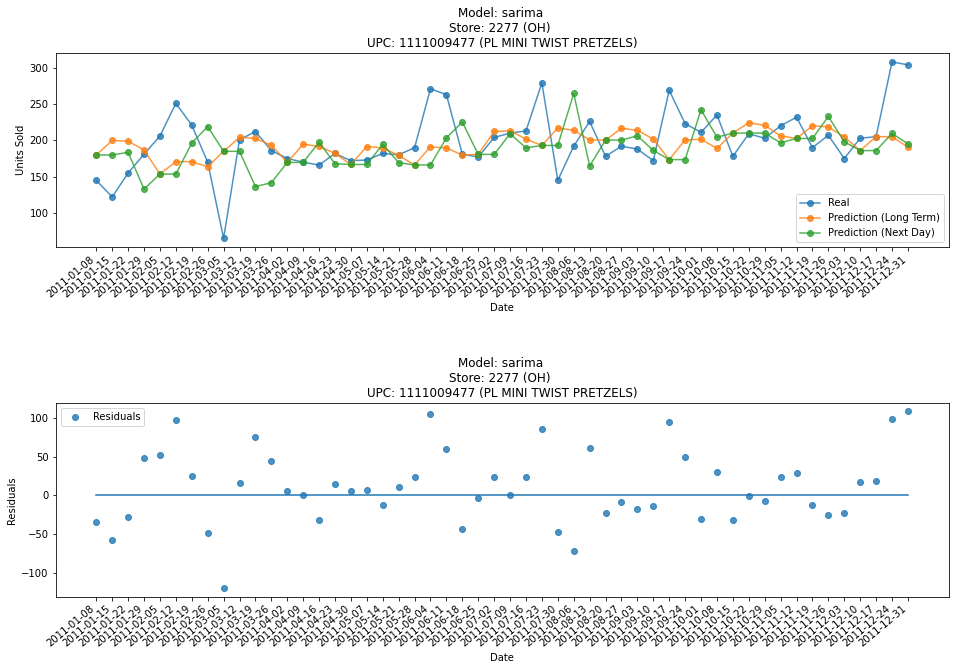

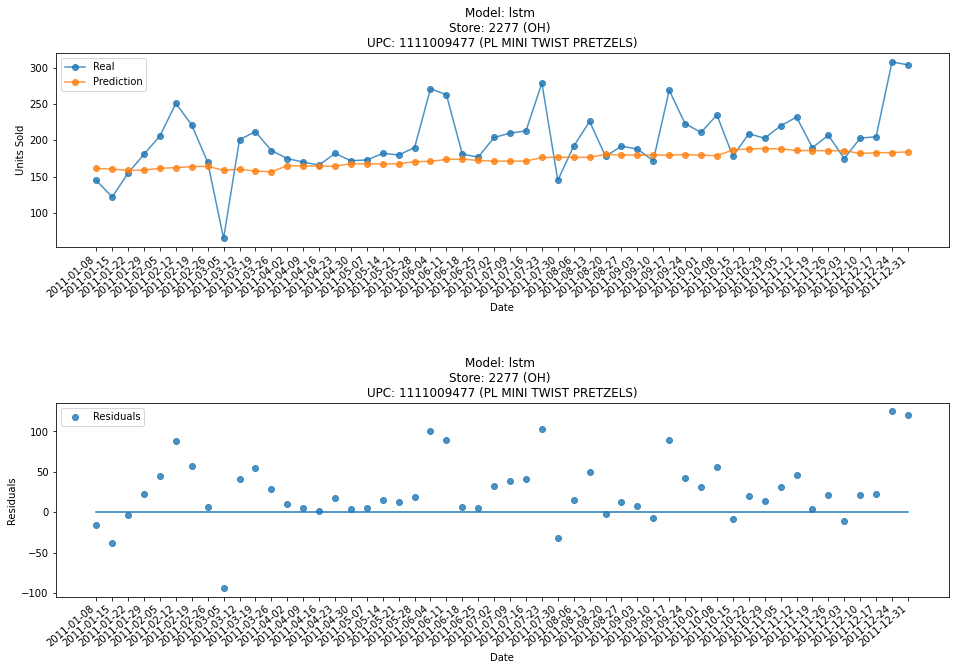

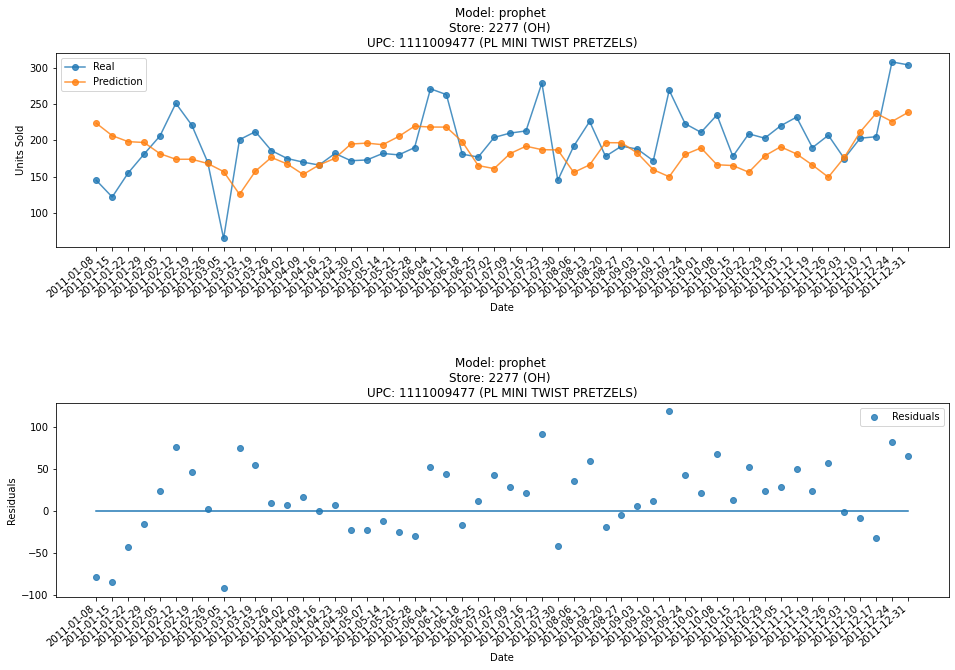

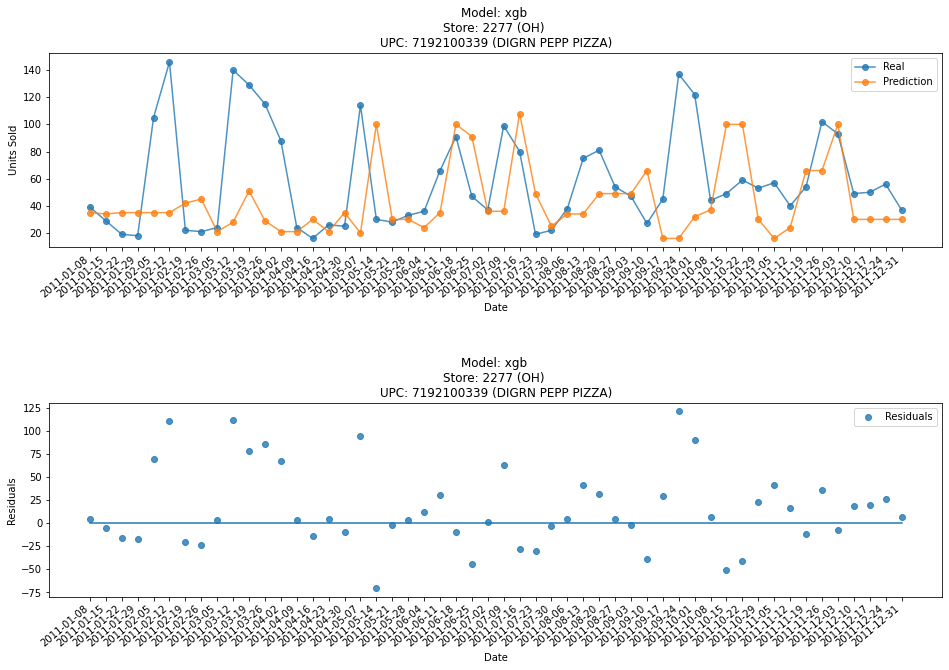

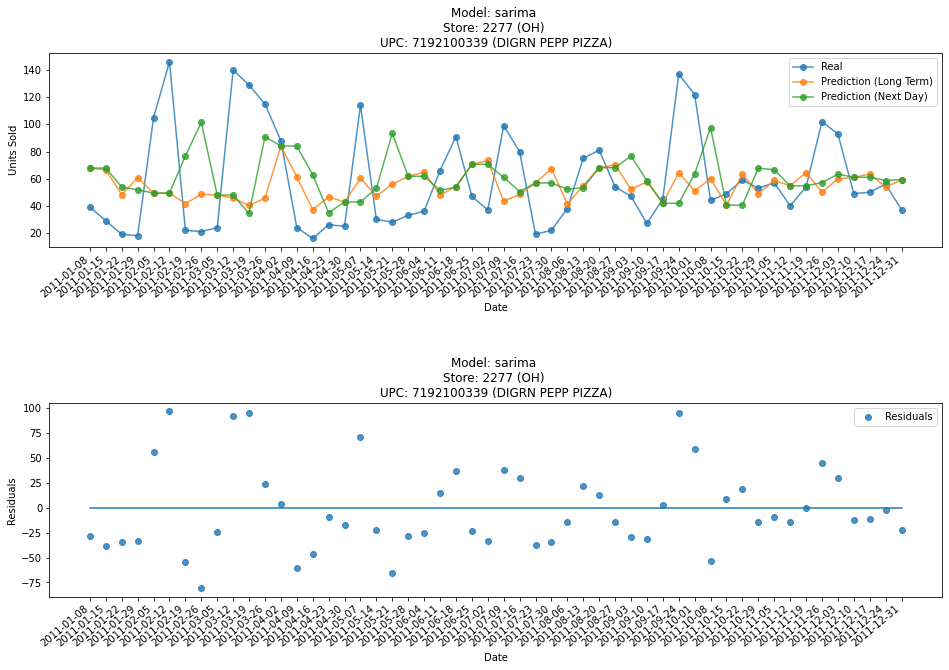

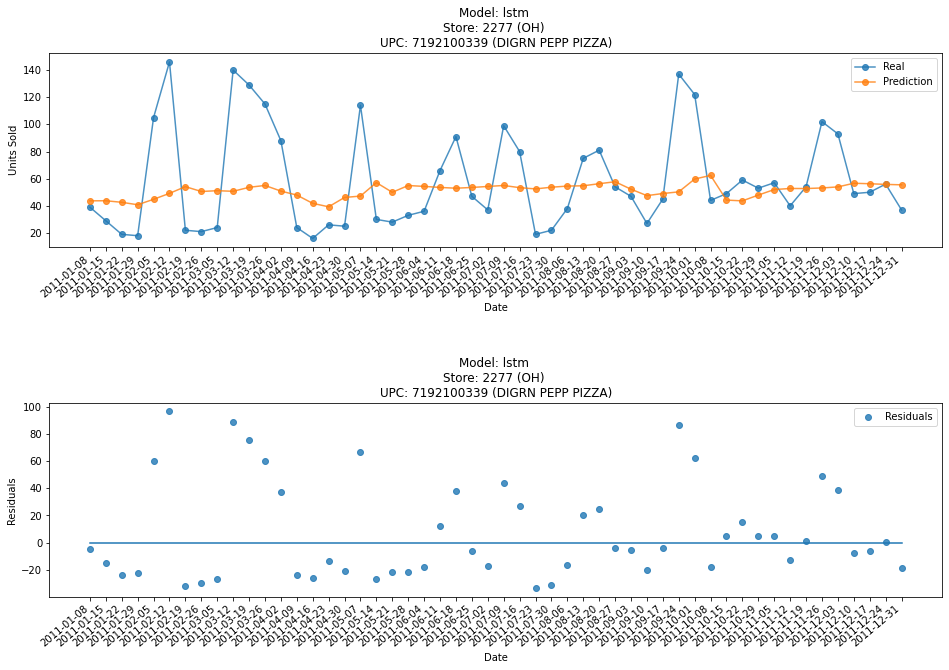

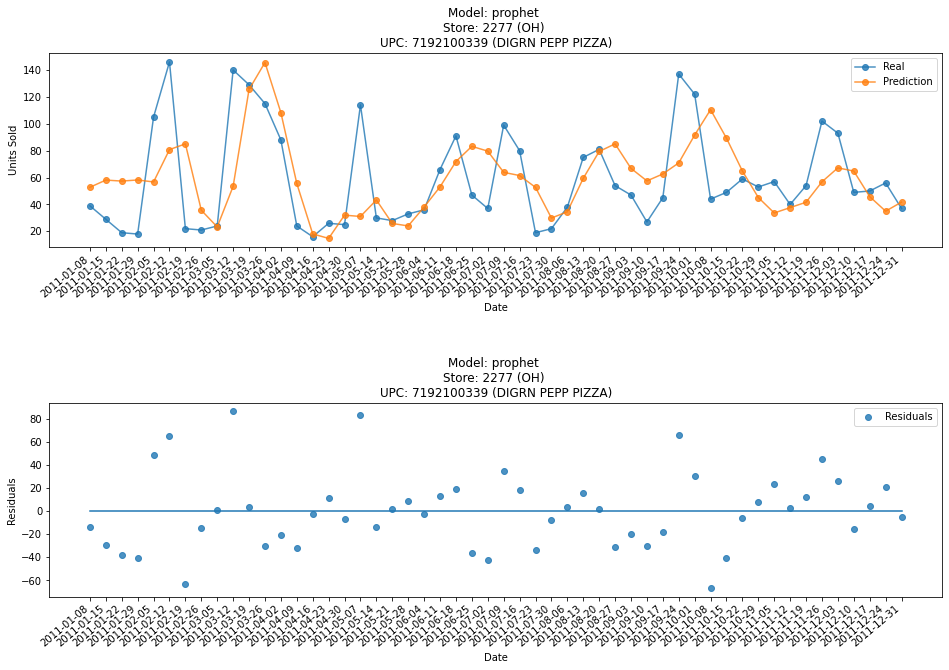

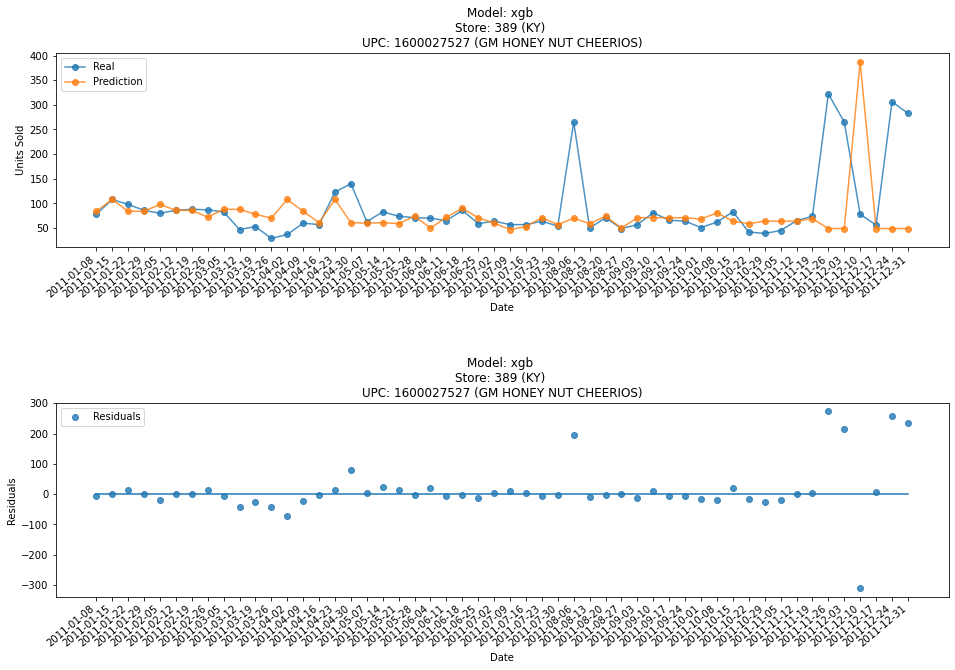

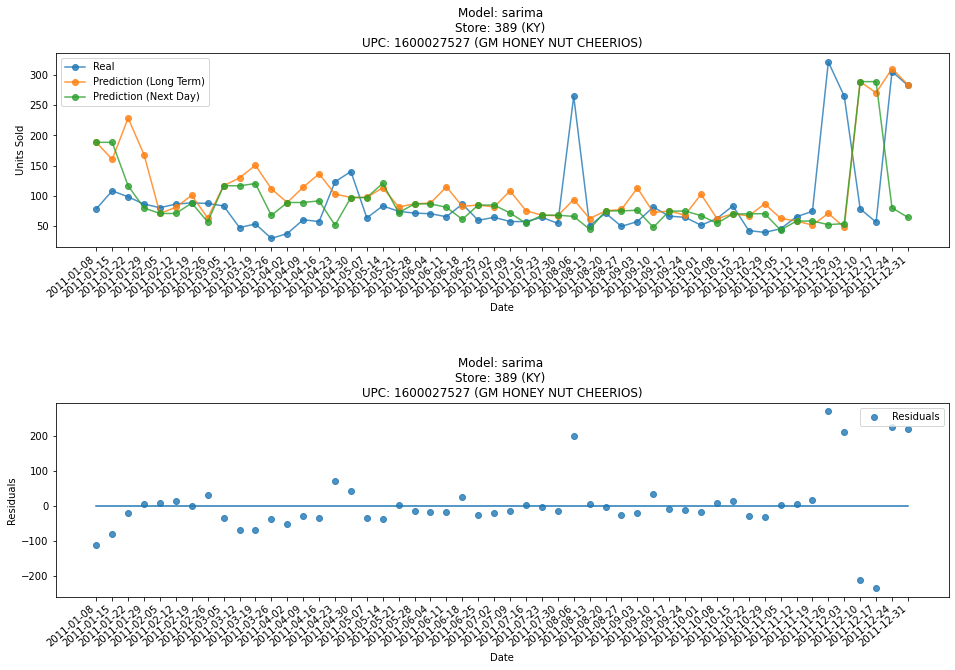

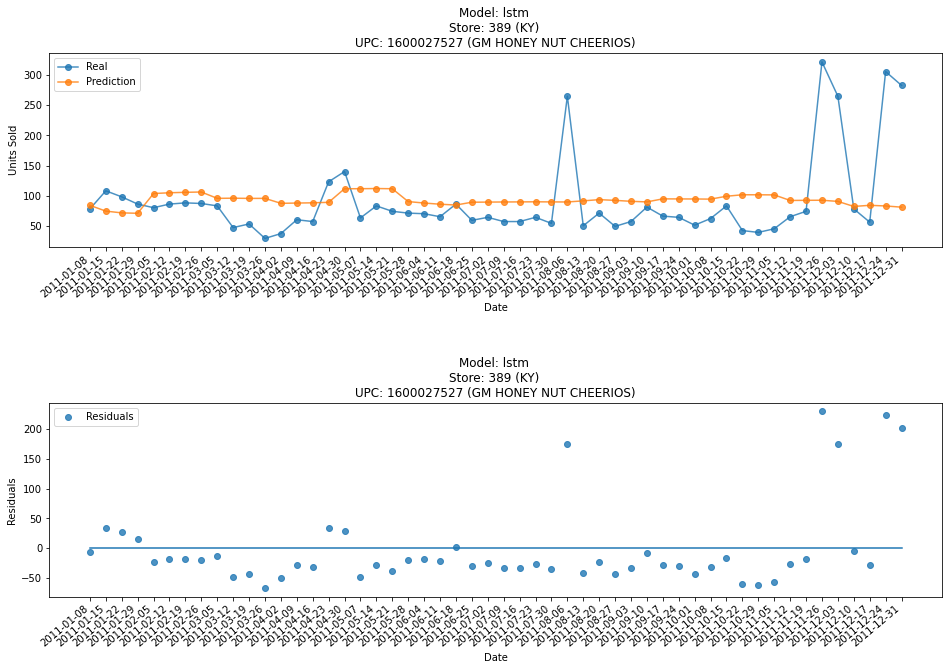

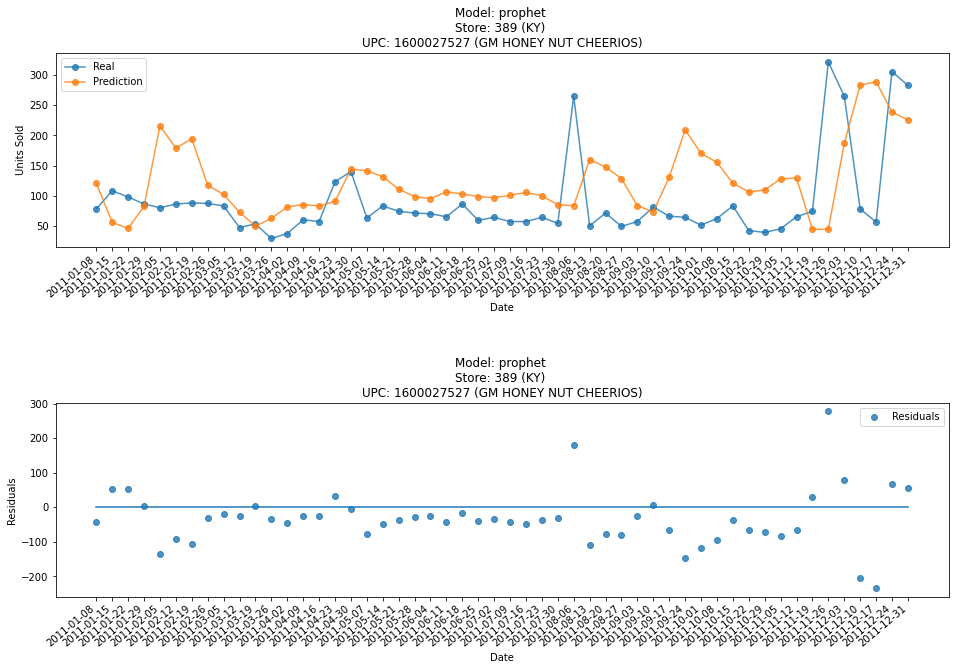

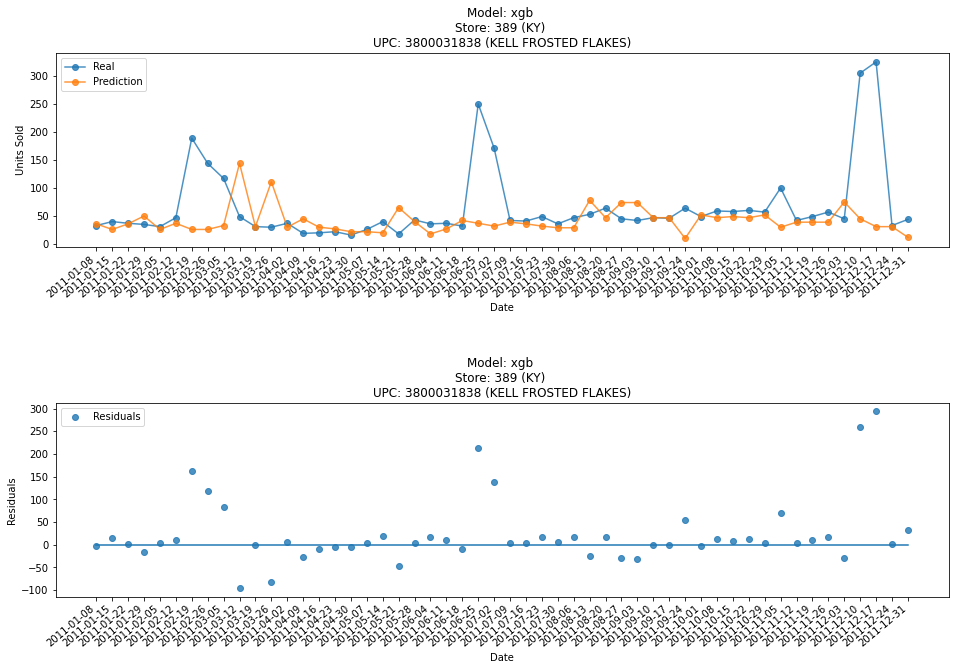

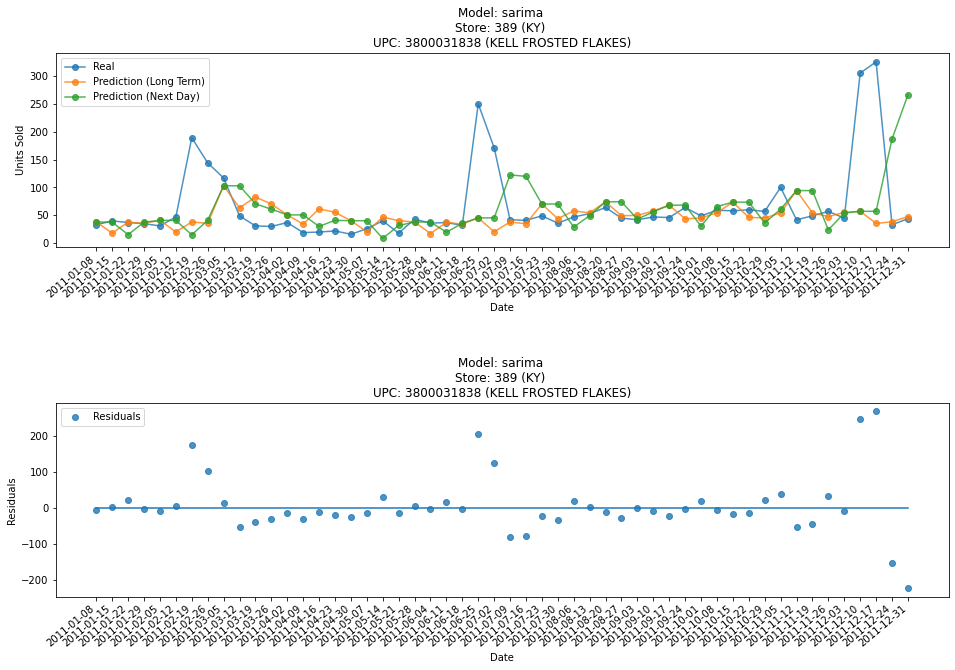

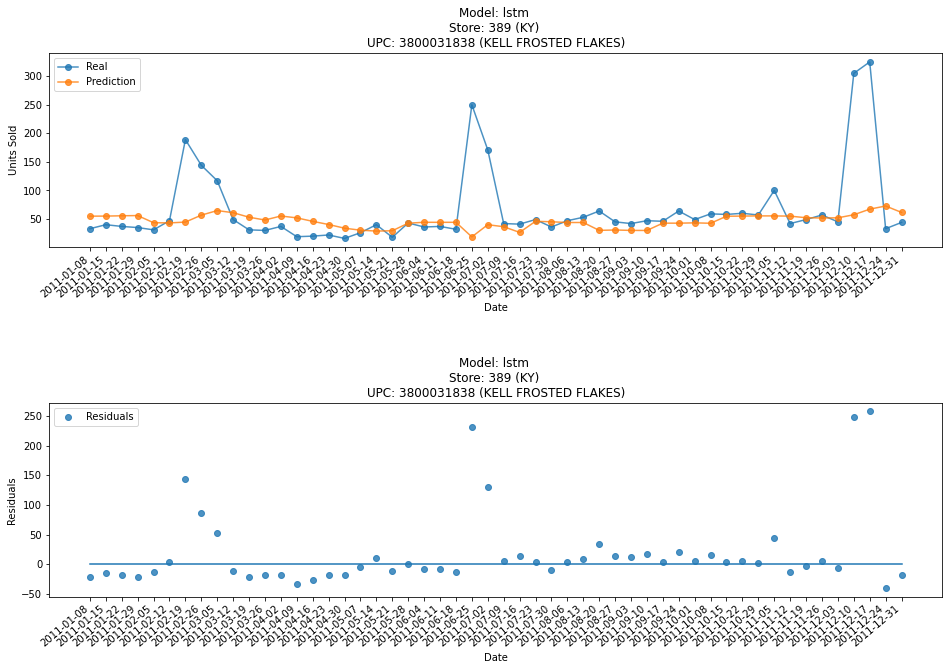

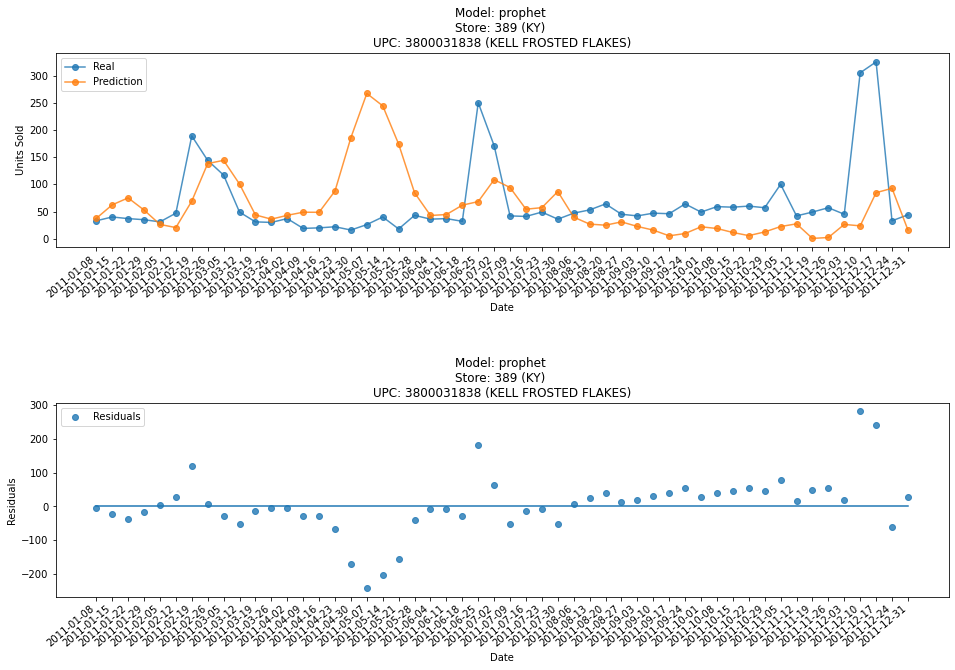

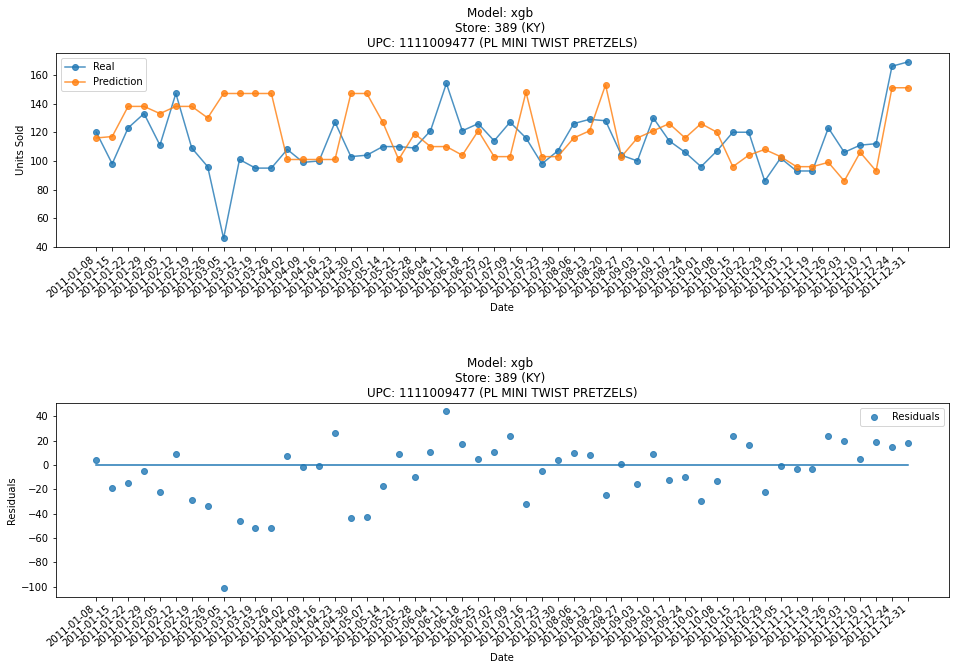

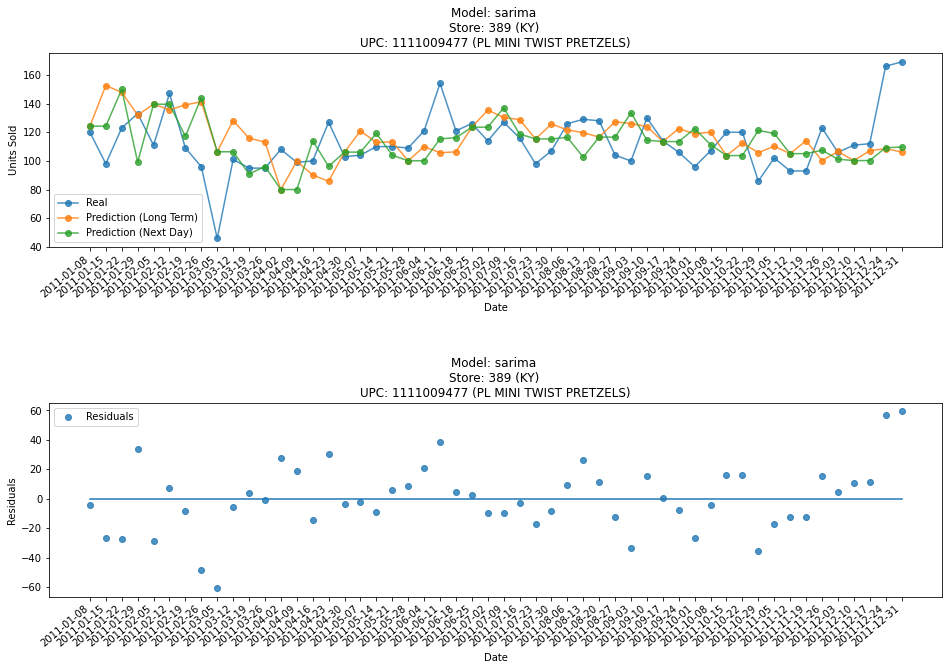

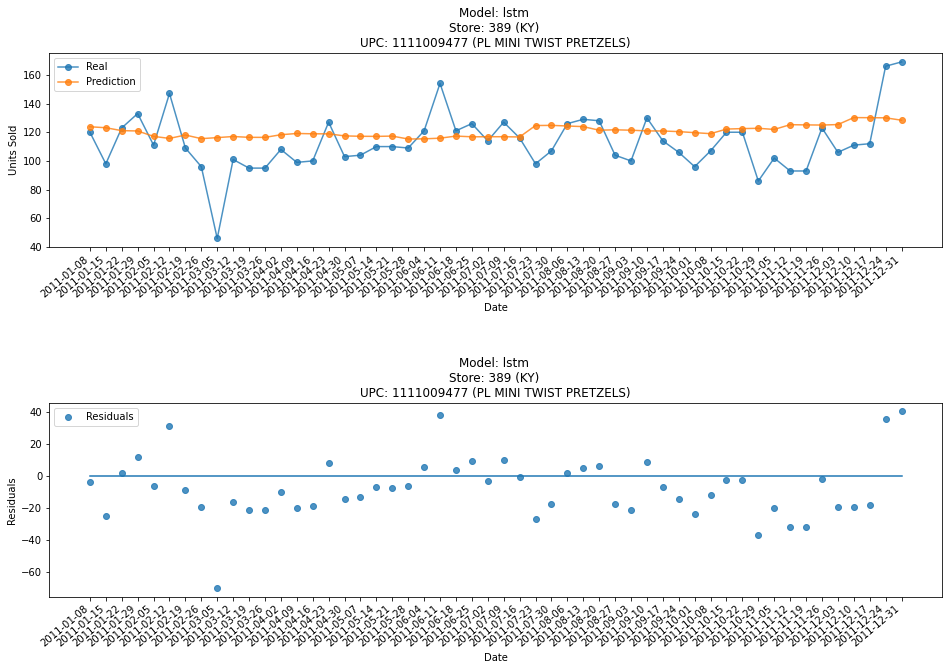

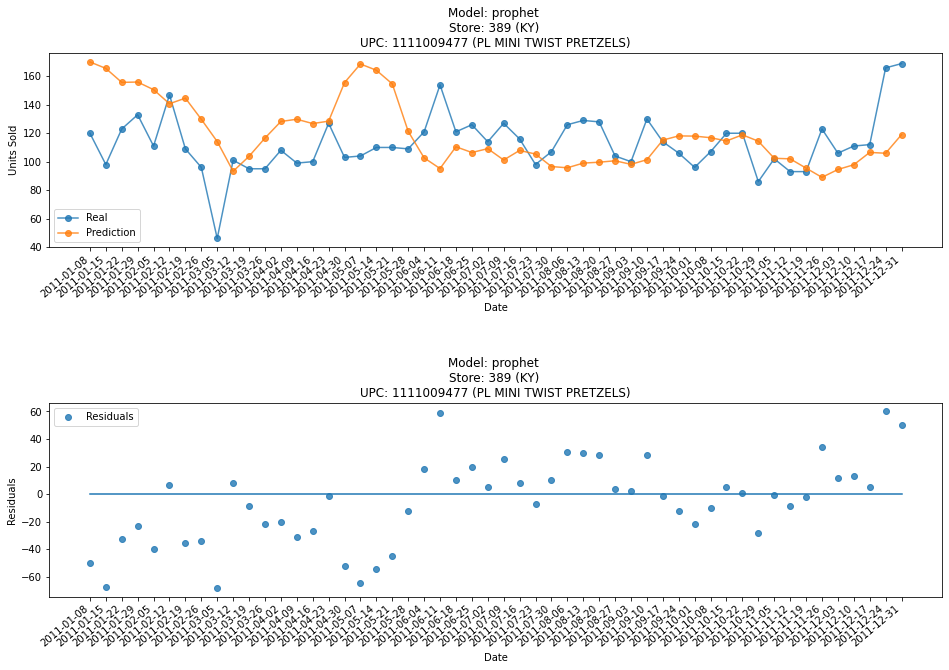

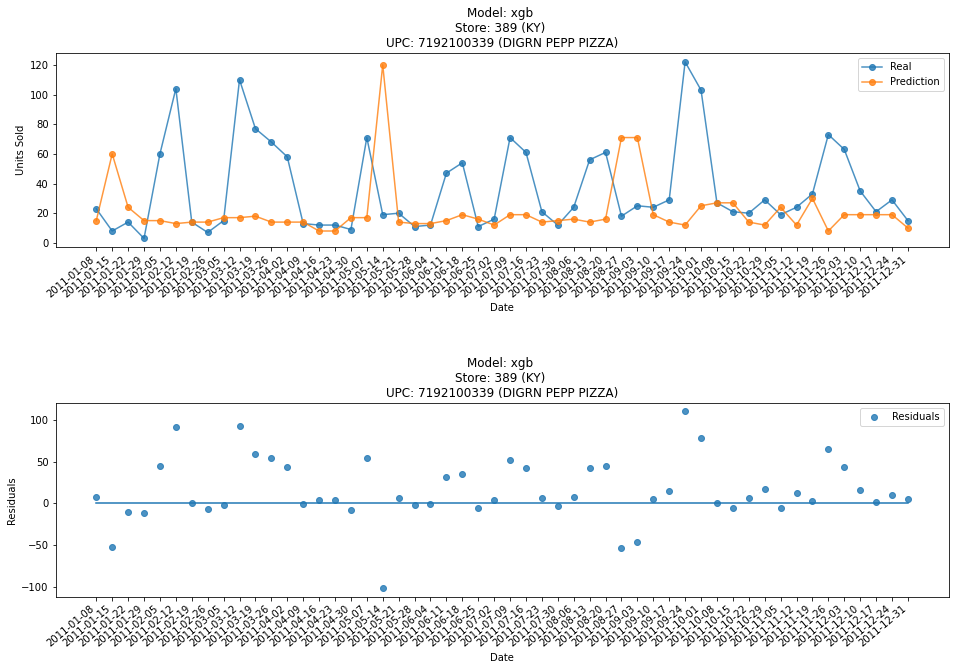

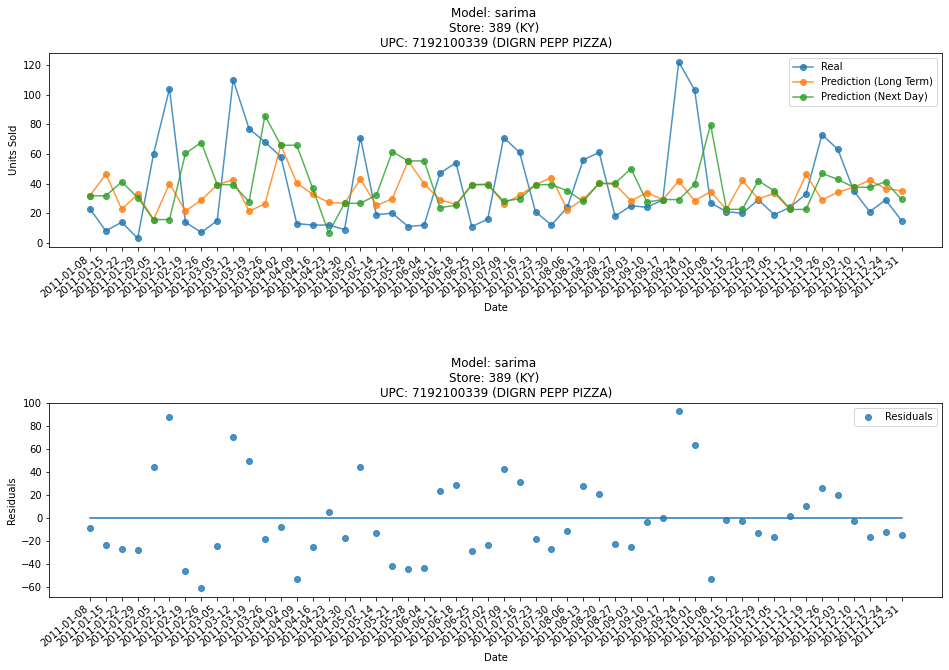

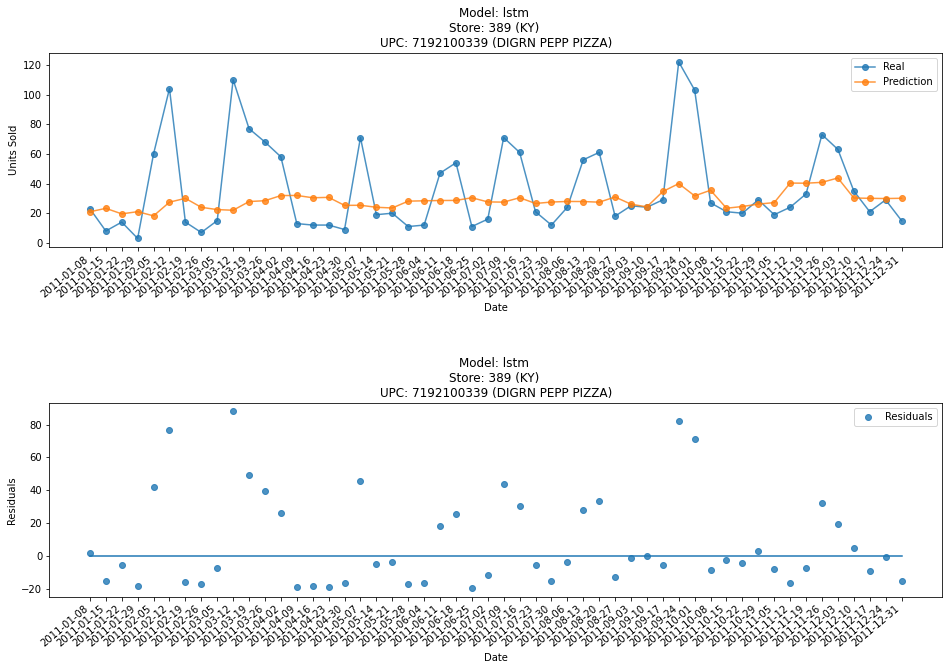

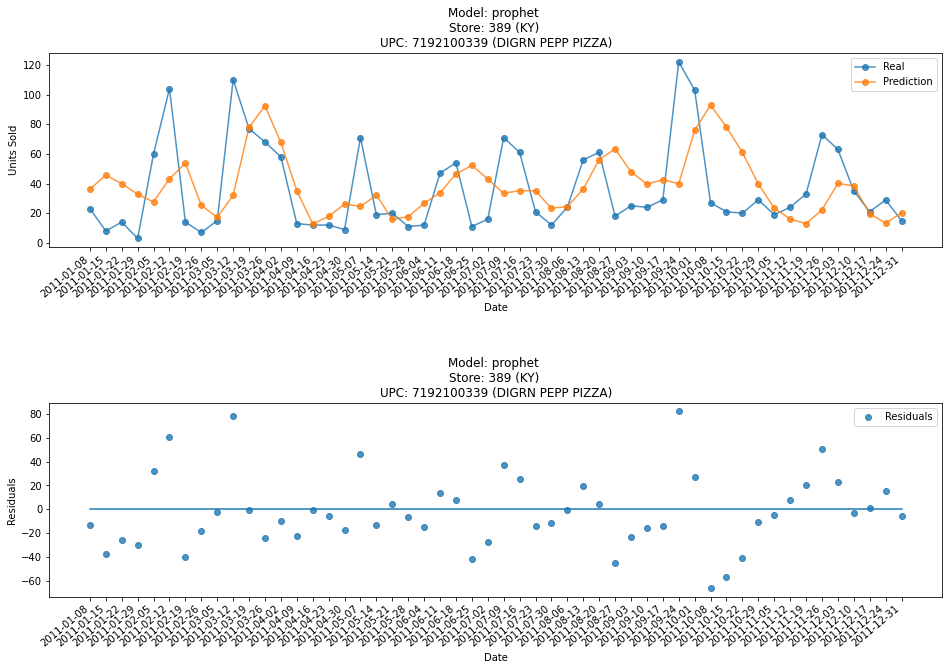

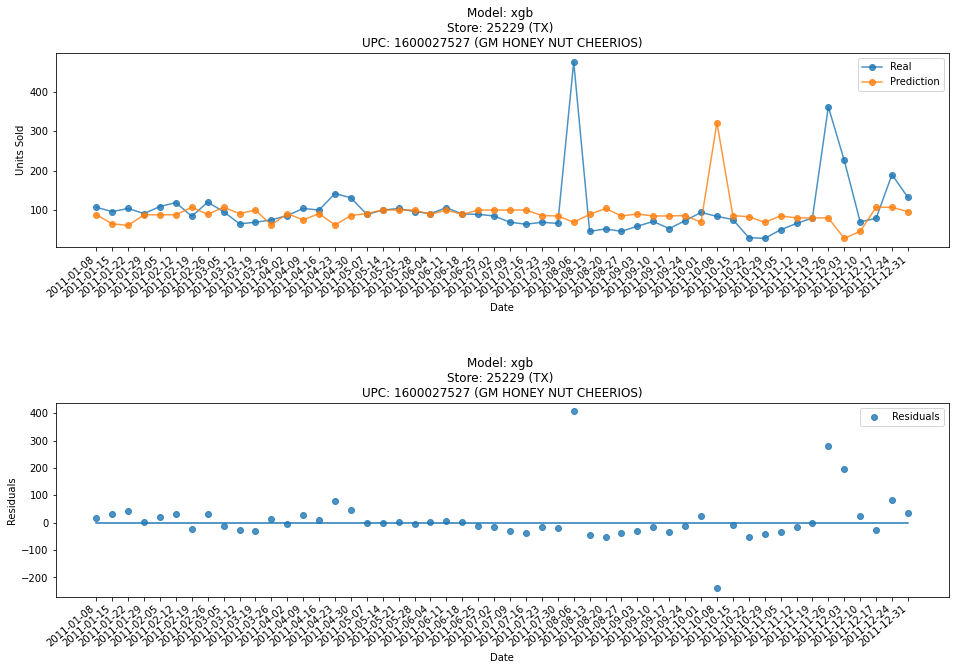

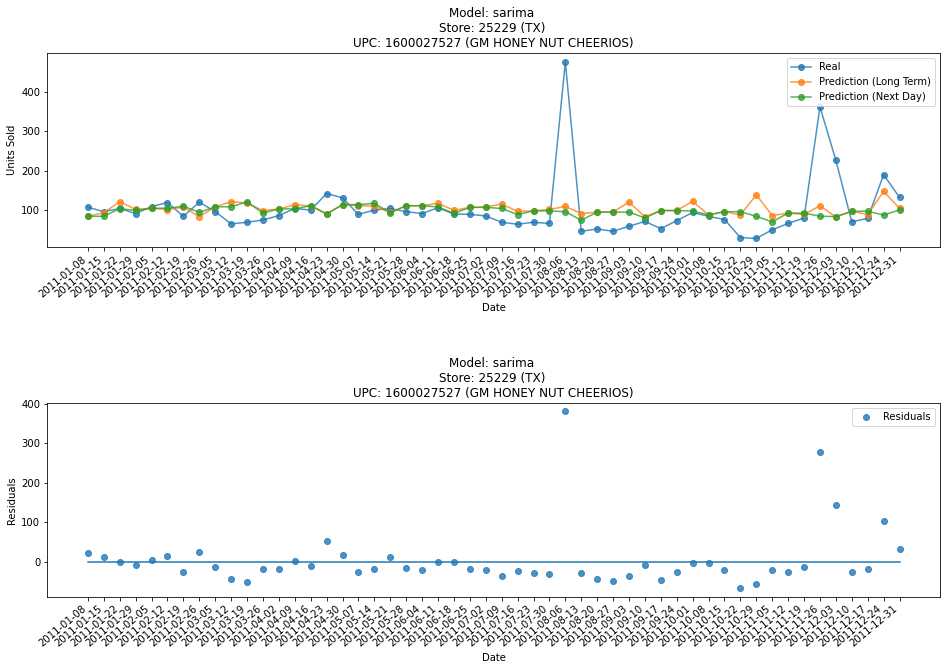

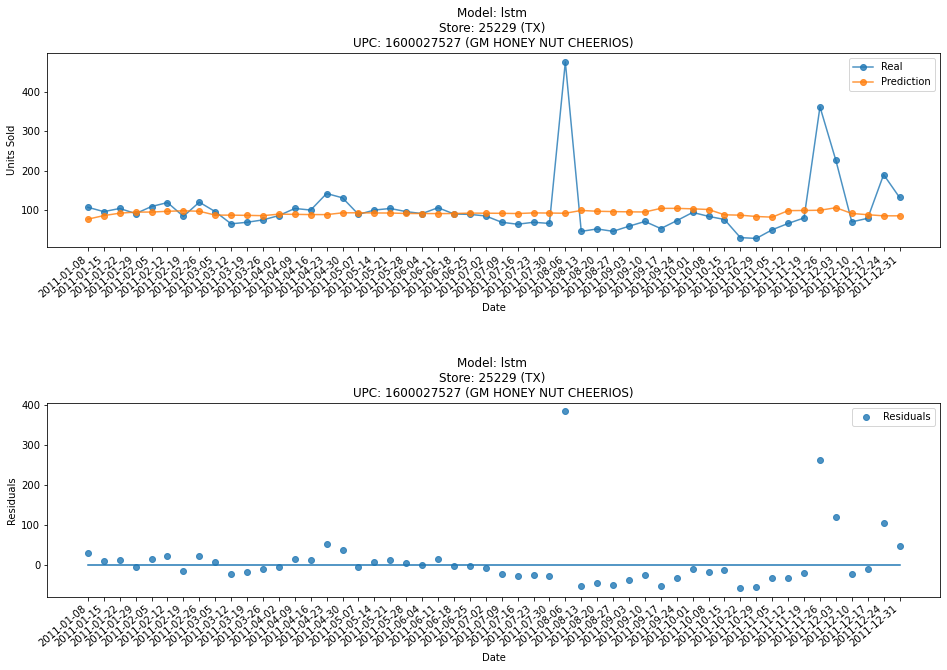

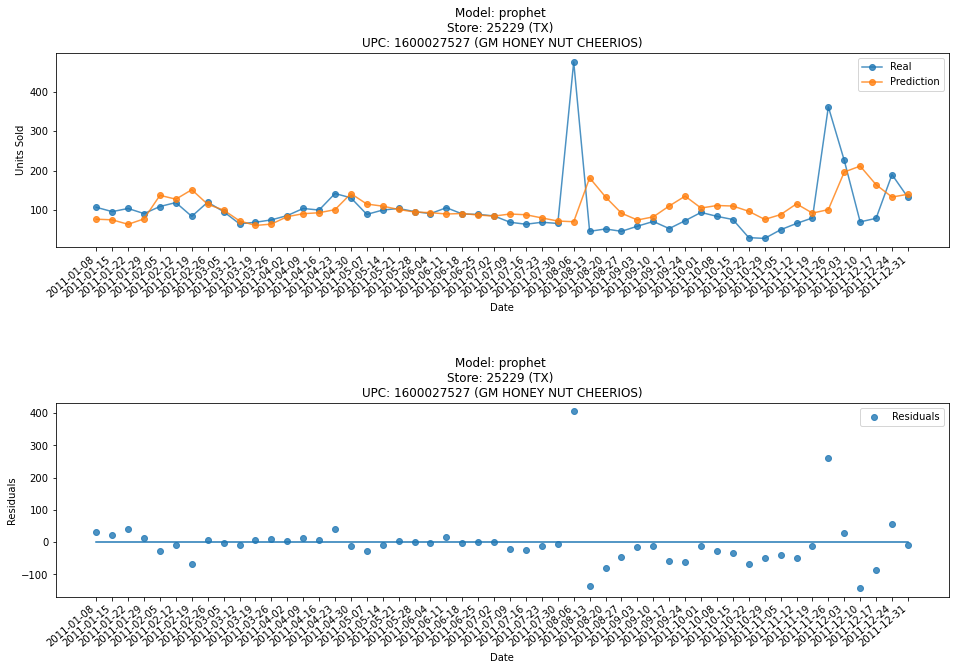

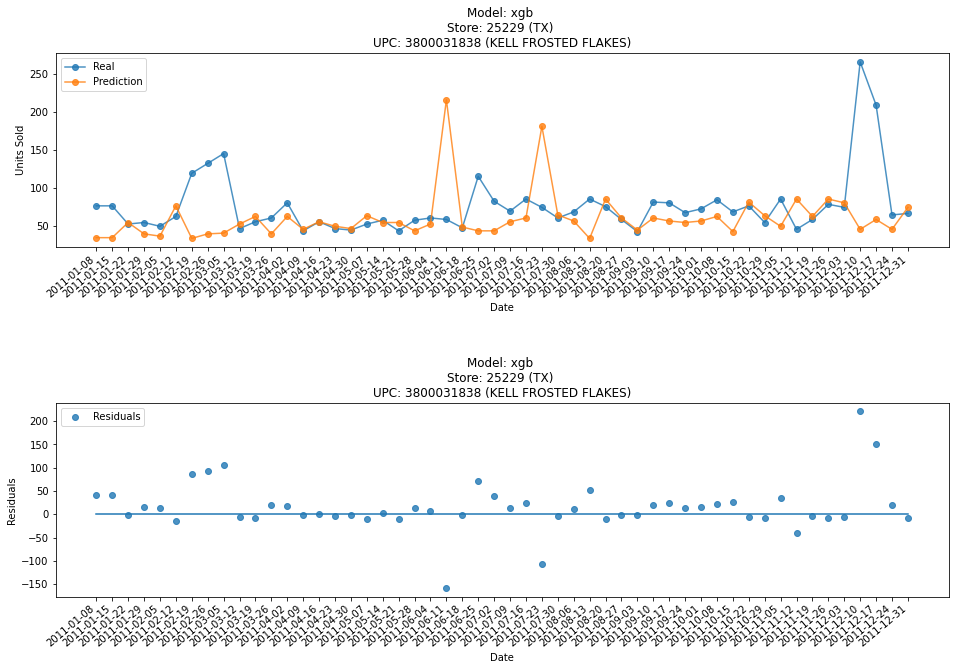

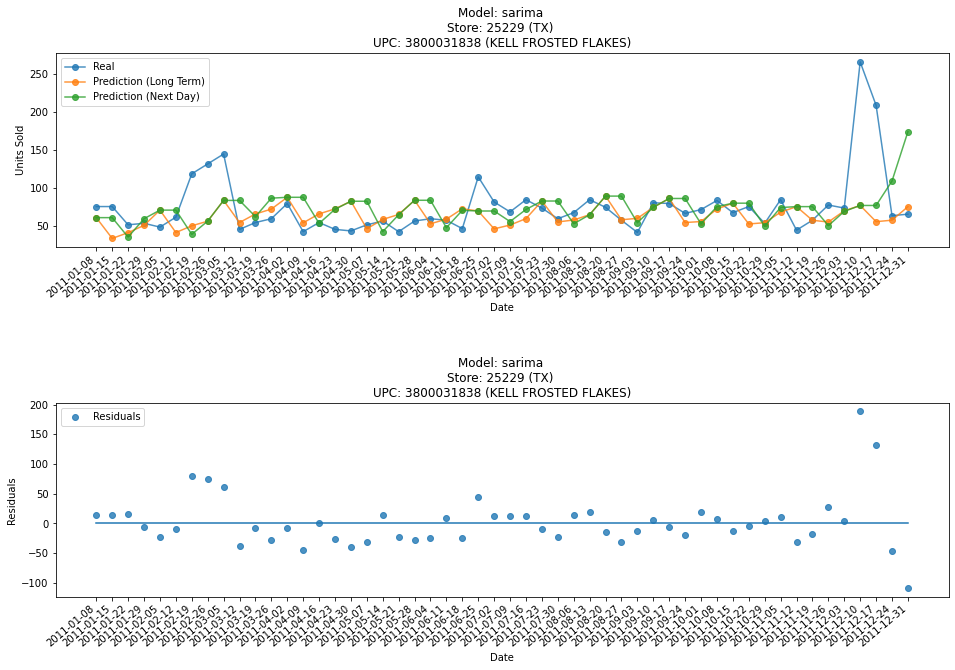

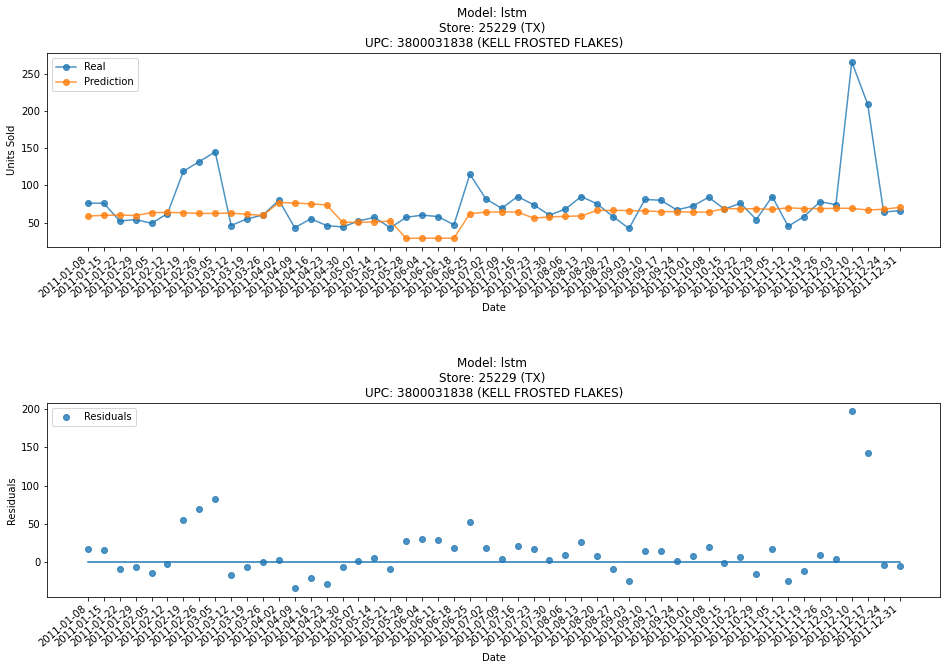

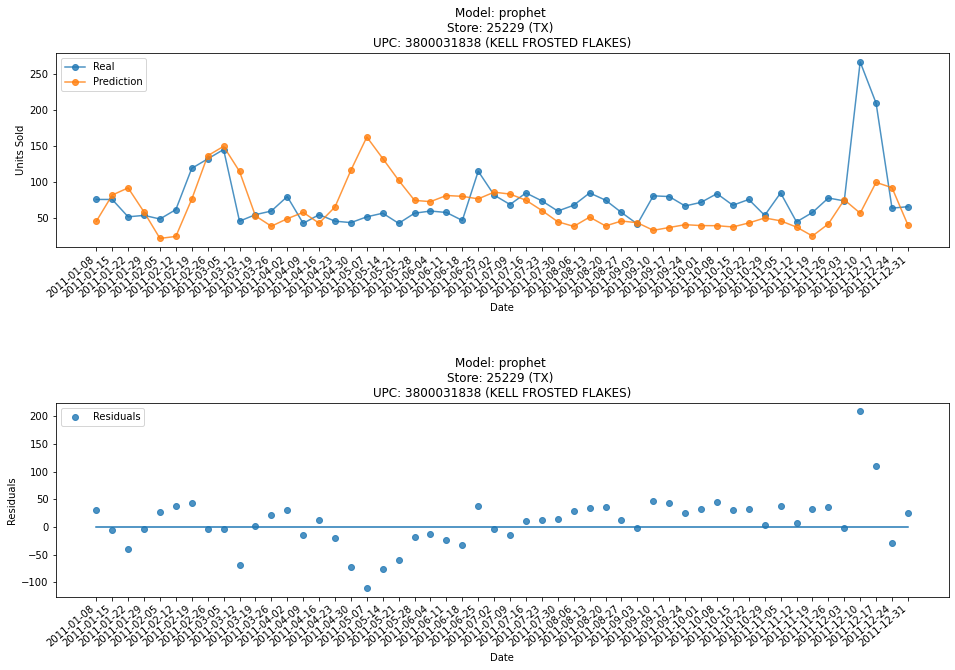

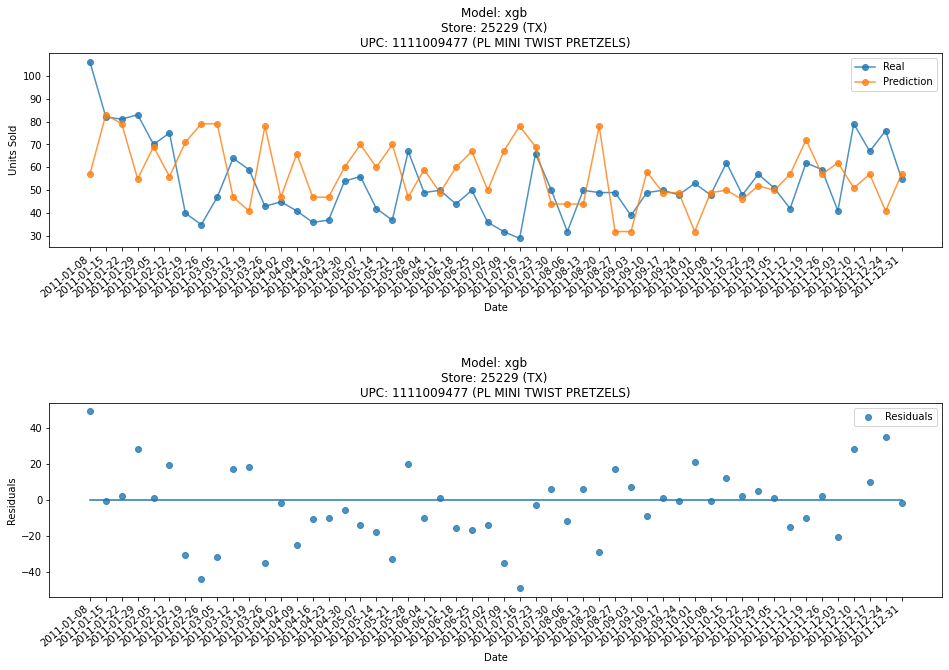

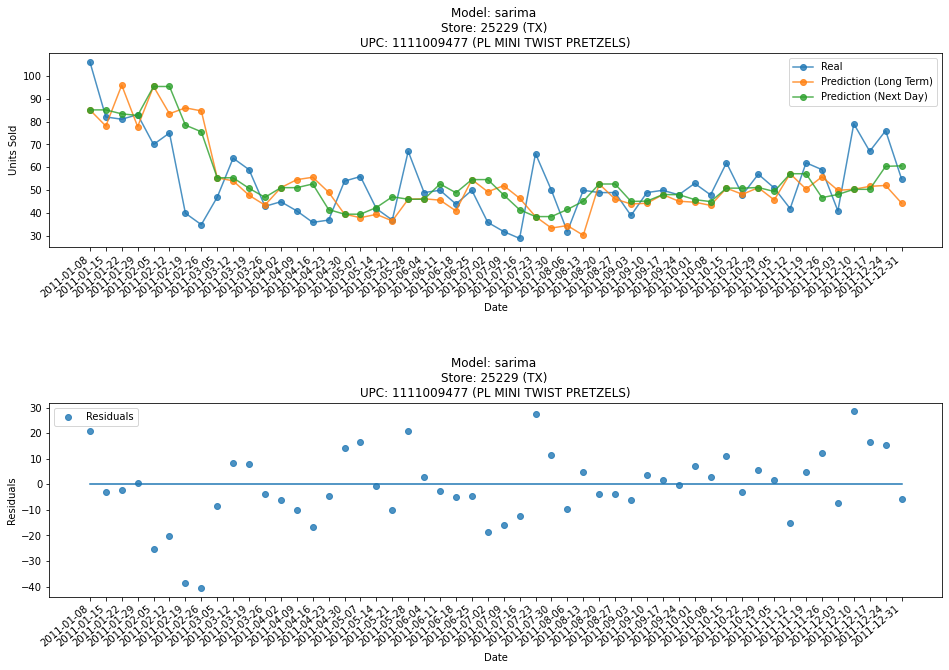

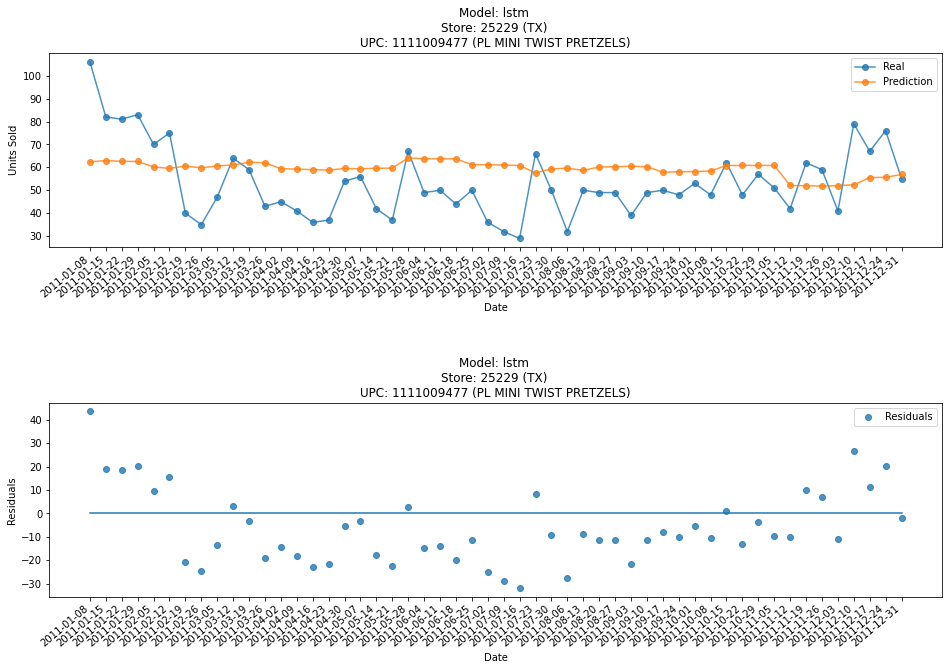

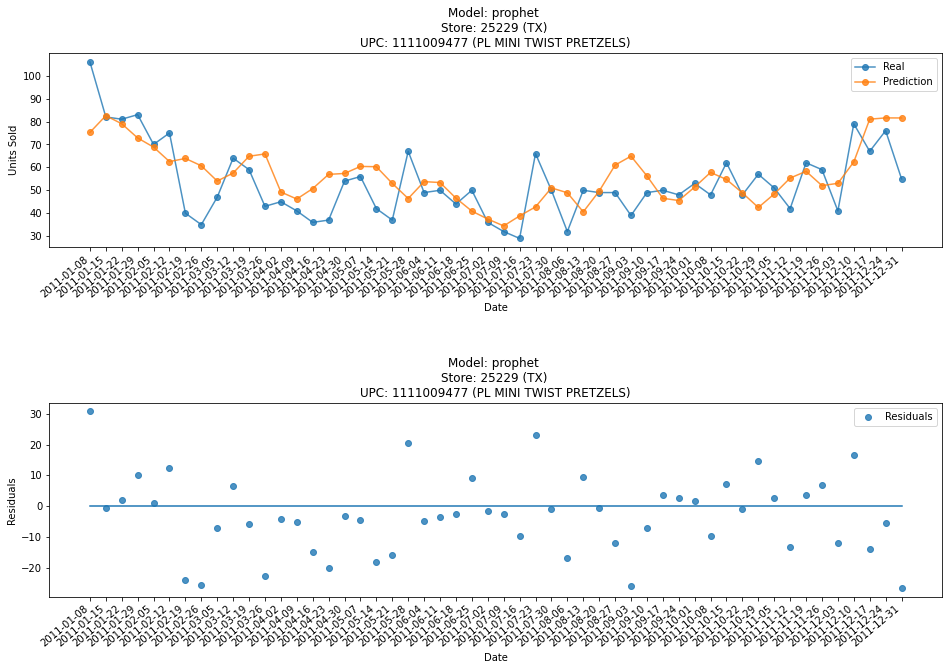

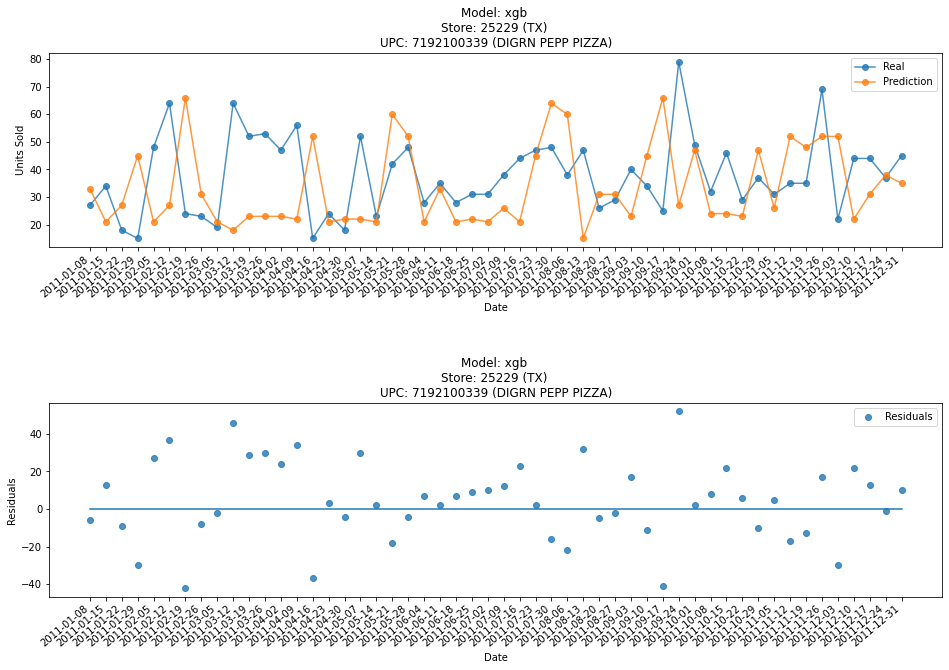

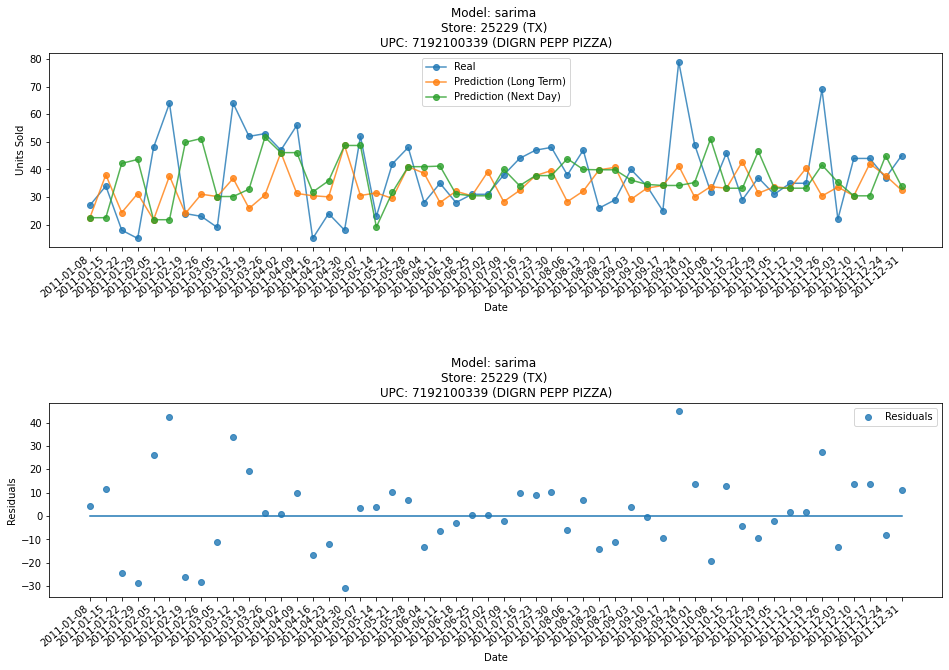

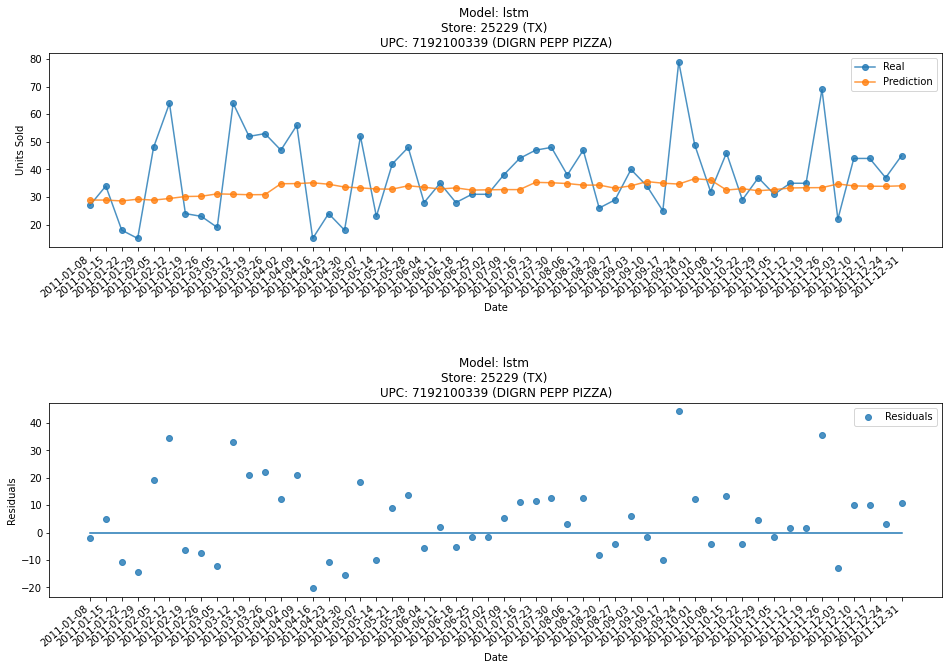

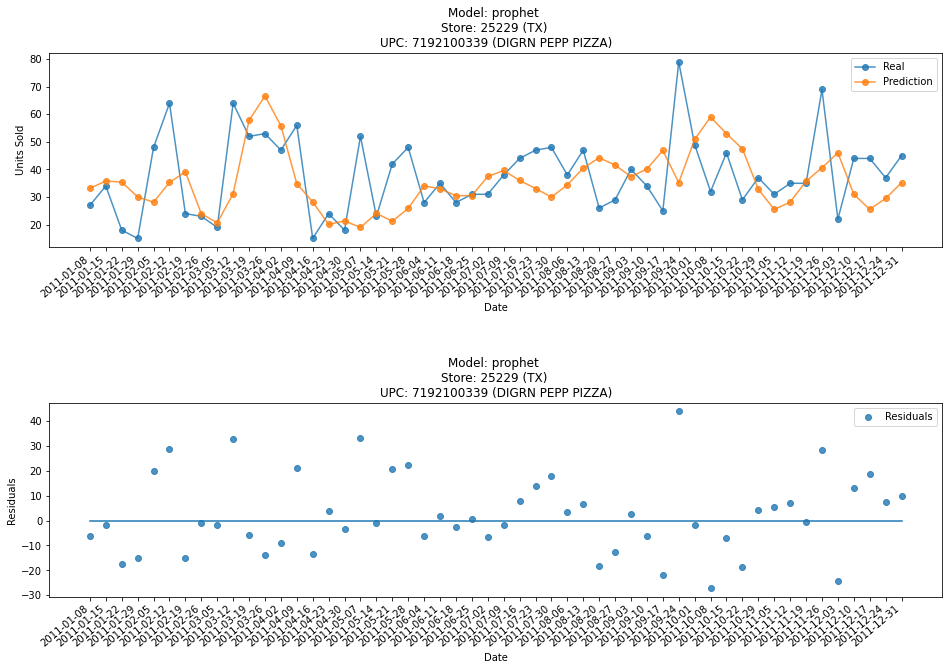

In [15]:
# Plot the forecast for each model

for store, upc in full_search:
    
    temp = all_stores_upc[f'{store}_{upc}']
    temp.sort_index(inplace=True)

    for model in ['xgb','sarima','lstm','prophet']:
        upc_name = lookup_products[lookup_products['UPC']==upc]['DESCRIPTION'].iloc[0]
        store_state = params['breakfast']['dataset']['store_ids'][store]
        
        fig, axs = plt.subplots(2, 1, figsize=(16,10))
        plt.subplots_adjust(hspace=0.8)
        
        # Forecasts
        axs[0].plot(temp['y_true'], marker='o', label='Real',alpha=0.8)
        if model == 'sarima':
            axs[0].plot(temp[f'y_pred_lt_{model}'], marker='o', label='Prediction (Long Term)',alpha=0.8)
            axs[0].plot(temp[f'y_pred_{model}'], marker='o', label='Prediction (Next Day)',alpha=0.8)
        else:
            axs[0].plot(temp[f'y_pred_{model}'], marker='o', label='Prediction',alpha=0.8)
        
#         axs[0].plot(temp[f'y_pred_{model}'], marker='o', label='Prediction',alpha=0.8)
        axs[0].set_title(f'Model: {model} \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Units Sold')
        axs[0].legend()
        for tick in axs[0].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        # Residuals
        axs[1].scatter(x=temp.index, y=(temp['y_true'] - temp[f'y_pred_{model}']), marker='o', label='Residuals', alpha=0.8)
        axs[1].plot([0]*temp.shape[0])
        axs[1].set_title(f'Model: {model} \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Residuals')
        axs[1].legend()
        for tick in axs[1].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
        
        plt.show()
        
    print('\n\n\n')